In [4860]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import normaltest
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score

In [4861]:
warnings.filterwarnings('ignore')

In [4862]:
data = pd.read_csv('train.csv')
train,test = train_test_split(data,train_size=0.7,random_state=100)

In [4863]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021 entries, 318 to 792
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1021 non-null   int64  
 1   MSSubClass     1021 non-null   int64  
 2   MSZoning       1021 non-null   object 
 3   LotFrontage    844 non-null    float64
 4   LotArea        1021 non-null   int64  
 5   Street         1021 non-null   object 
 6   Alley          64 non-null     object 
 7   LotShape       1021 non-null   object 
 8   LandContour    1021 non-null   object 
 9   Utilities      1021 non-null   object 
 10  LotConfig      1021 non-null   object 
 11  LandSlope      1021 non-null   object 
 12  Neighborhood   1021 non-null   object 
 13  Condition1     1021 non-null   object 
 14  Condition2     1021 non-null   object 
 15  BldgType       1021 non-null   object 
 16  HouseStyle     1021 non-null   object 
 17  OverallQual    1021 non-null   int64  
 18  Overall

In [4864]:
original_columns = list(train.columns)

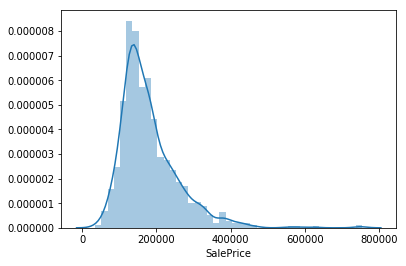

In [4865]:
sb.distplot(train['SalePrice'])

We see that the sale price is skewed to the left and there are some major outliers to the right

In [4866]:
stat,p=normaltest(train['SalePrice'])
print(f'p_value : {p}')

p_value : 4.050426894080129e-99


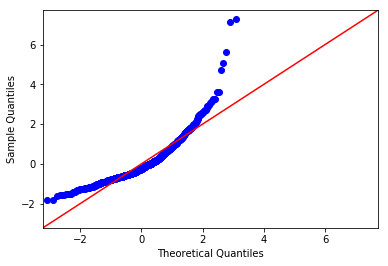

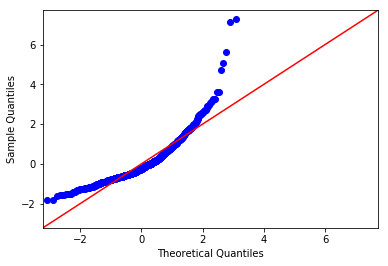

In [4867]:
qqplot(train['SalePrice'],fit=True,line='45')

Both from the p-value and q-q plot we see that the dependent varible is violating the homoscedasticity assumption of linear regression.

In [4868]:
pt = PowerTransformer(method='yeo-johnson',standardize=False)
train['SalePrice'] = pt.fit_transform(train[['SalePrice']])

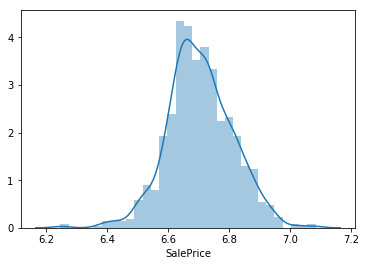

In [4869]:
sb.distplot(train['SalePrice'])

In [4870]:
stat,p=normaltest(train['SalePrice'])
print(f'p_value : {p}')

p_value : 0.0006681837288390412


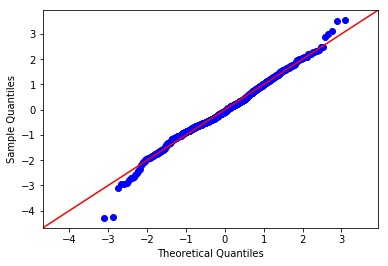

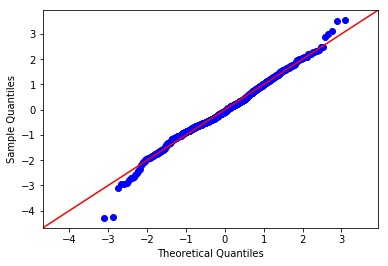

In [4871]:
qqplot(train['SalePrice'],fit=True,line='45')

In [4872]:
def boxplot_cat(column_name,size=(10,10),rot=0):
    df = train.groupby(column_name)['SalePrice'].median().sort_values().reset_index()
    plt.figure(figsize=size)
    plt.xticks(rotation=rot)
    sb.boxplot(x=train[column_name],y=train['SalePrice'],order=df[column_name])

def cook_distance(model,column,train_X):
    column_cook = model.get_influence()
    (c, p) = column_cook.cooks_distance
    plt.stem(np.arange( len( train_X) ), np.round( c, 3 ),  markerfmt="," )
    plt.title( f"Cooks distance for all observations of column {column}" )
    plt.xlabel("Row index")
    plt.ylabel("Cooks Distance")
    cm = np.mean(c)
    cl = list(np.round( c, 3 ))
    for i in range(len(cl)):
        if cl[i]>=1:
            print(f'Highly influential value with c>1: {train_X.iloc[i]} at index {i}')
        if cl[i]>=3*cm:
            print(f'Influential value with c>3*mean: {train_X.iloc[i]} at index {i}')
            
def group_count(column):
    print(100*train.groupby(column)['Id'].count()/len(train))

# Univariate and Bivariate Analysis

In [4873]:
train['MSSubClass'].unique()

array([ 60,  50, 190,  80,  90,  70,  20,  30,  75, 120, 180, 160,  45,
        85,  40], dtype=int64)

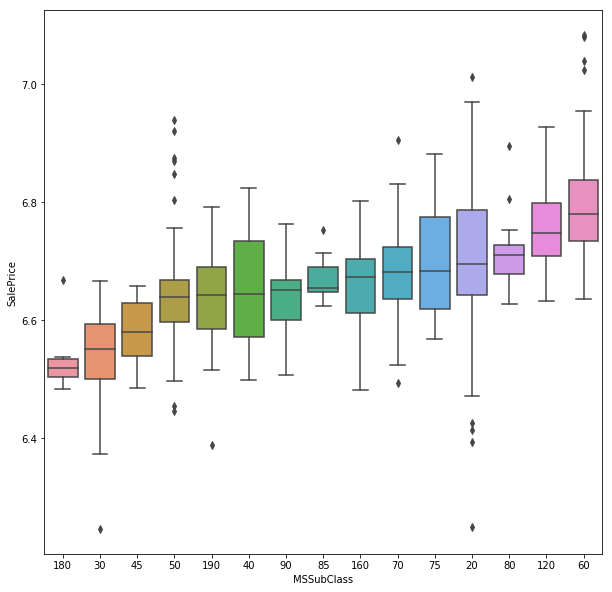

In [4874]:
boxplot_cat('MSSubClass')

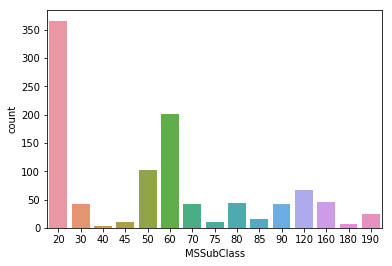

In [4875]:
sb.countplot(train['MSSubClass'])

Two points to note about MSSubClass:
* An increase in price is observed for change in subclass
* The numerical labels provided are not ordinal and thus have no numeric significance
#### Therefore we use dummy variables for each class

In [4876]:
group_count('MSSubClass')

MSSubClass
20     35.847209
30      4.113614
40      0.293830
45      1.077375
50     10.088149
60     19.686582
70      4.113614
75      0.979432
80      4.211557
85      1.469148
90      4.113614
120     6.464251
160     4.505387
180     0.587659
190     2.448580
Name: Id, dtype: float64


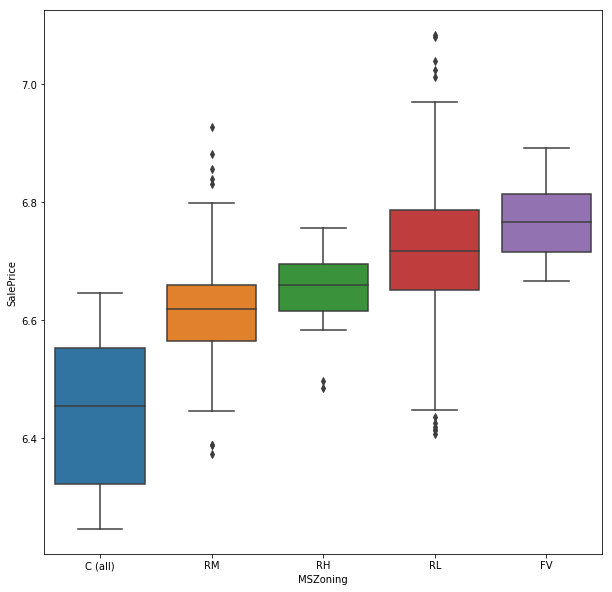

In [4877]:
boxplot_cat('MSZoning')

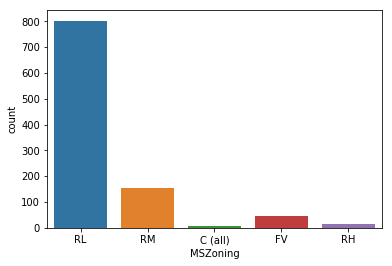

In [4878]:
sb.countplot(train['MSZoning'])

In [4879]:
100*train.groupby('MSZoning')['Id'].count()/len(train)

MSZoning
C (all)     0.685602
FV          4.407444
RH          1.273262
RL         78.550441
RM         15.083252
Name: Id, dtype: float64

Points to note about MSZoning:
* Data distribution across class is skewed, RL contains 78% data, RM contains 15% while others have very less data
* There is significant distinction between median price of RM and RL. Thus making this variable important

We can observe that 

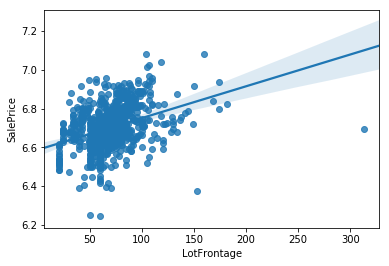

In [4880]:
sb.regplot(y=train['SalePrice'],x=train['LotFrontage'])

* We see that some pretty high leverage points are present for LotFrontage. This can be removed by simply removing the outliers specific to LotFrontage

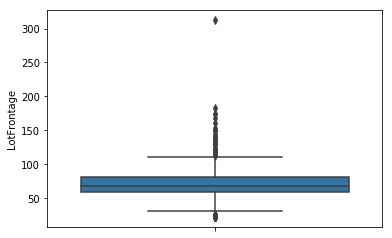

In [4881]:
sb.boxplot(y=train['LotFrontage'])

Influential value with c>3*mean: 105.0 at index 14
Influential value with c>3*mean: 153.0 at index 40
Influential value with c>3*mean: 105.0 at index 77
Influential value with c>3*mean: 42.0 at index 251
Influential value with c>3*mean: 160.0 at index 289
Highly influential value with c>1: 313.0 at index 316
Influential value with c>3*mean: 313.0 at index 316
Influential value with c>3*mean: 50.0 at index 376
Influential value with c>3*mean: 120.0 at index 405
Influential value with c>3*mean: 32.0 at index 593
Influential value with c>3*mean: 118.0 at index 614
Influential value with c>3*mean: 40.0 at index 662
Influential value with c>3*mean: 104.0 at index 684
Influential value with c>3*mean: 107.0 at index 742
Influential value with c>3*mean: 60.0 at index 784


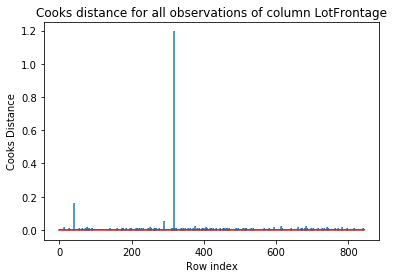

In [4882]:
Ols = sm.OLS(train[train['LotFrontage'].notnull()]['SalePrice'],sm.add_constant(train[train['LotFrontage'].notnull()]['LotFrontage'])).fit()
cook_distance(Ols,'LotFrontage',train[train['LotFrontage'].notnull()]['LotFrontage'])

From above we see that only one value 313 is having greater than 1 cook's distance. So it is a high leverage point.

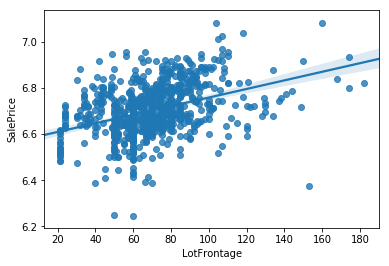

In [4883]:
LotFrontage = train[train['LotFrontage']<313]['LotFrontage']
salePrice = train[train['LotFrontage']<313]['SalePrice']
sb.regplot(y=salePrice,x=LotFrontage)

We see above removing the leverage points improved the fit considerably.

In [4884]:
print('Number of null values: ',len(train[train['LotFrontage'].isna()]),' Percent of null values: ',len(train[train['LotFrontage'].isna()])/len(train))

Number of null values:  177  Percent of null values:  0.1733594515181195


We see that 177 null values are present. There is another variable lot shape. Now in general lot frontage is highly dependent on lot shape. So, we impute the group-wise summary statistics as the value.

In [4885]:
print(train[train['LotFrontage']<313].groupby('LotShape')['LotFrontage'].median())
print(train[train['LotFrontage']<313].groupby('LotShape')['LotFrontage'].mean())
print(train[train['LotFrontage']<313].groupby('LotShape')['LotFrontage'].count())
print(train['LotFrontage'].mean())

LotShape
IR1     74.0
IR2     57.0
IR3    150.0
Reg     65.0
Name: LotFrontage, dtype: float64
LotShape
IR1     77.224215
IR2     66.526316
IR3    118.000000
Reg     66.156040
Name: LotFrontage, dtype: float64
LotShape
IR1    223
IR2     19
IR3      5
Reg    596
Name: LotFrontage, dtype: int64
69.68838862559242


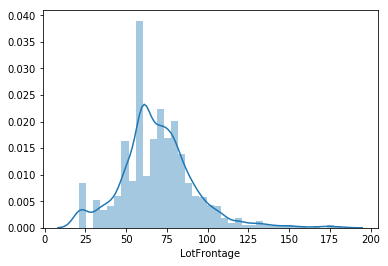

In [4886]:
sb.distplot(train[train['LotFrontage']<313]['LotFrontage'])

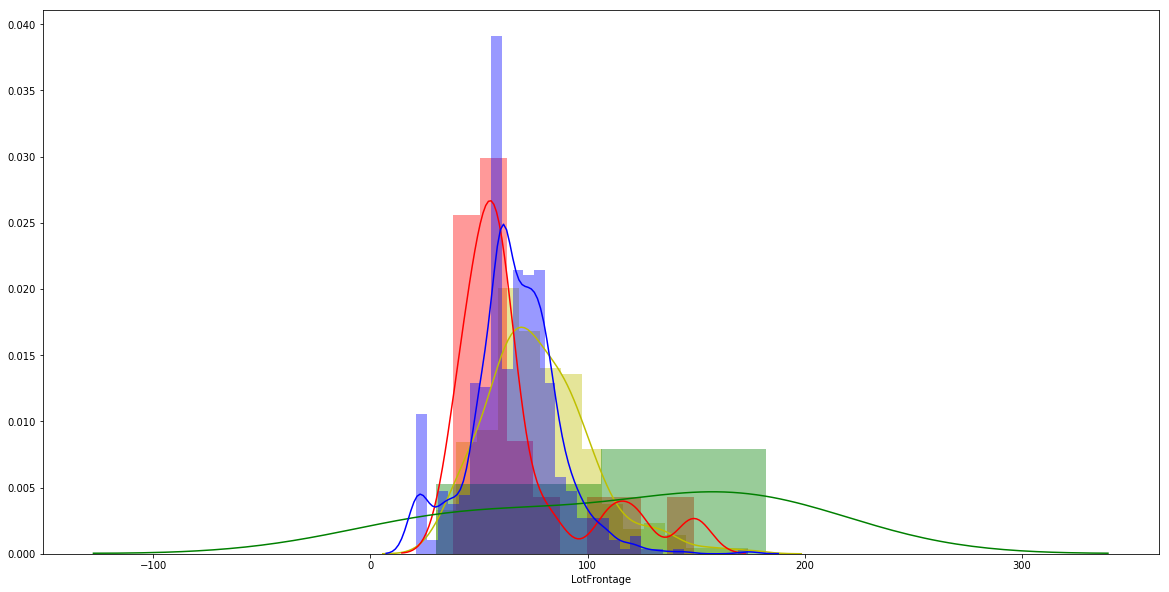

In [4887]:
plt.figure(figsize=(20,10))
sb.distplot(train[(train['LotShape']=='IR1') & (train['LotFrontage'].notnull()) & (train['LotFrontage']<313)]['LotFrontage'],color='y',label='IR1')
sb.distplot(train[(train['LotShape']=='IR2') & (train['LotFrontage'].notnull()) & (train['LotFrontage']<313)]['LotFrontage'],color='r',label='IR2')
sb.distplot(train[(train['LotShape']=='IR3') & (train['LotFrontage'].notnull()) & (train['LotFrontage']<313)]['LotFrontage'],color='g',label='IR3')
sb.distplot(train[(train['LotShape']=='Reg') & (train['LotFrontage'].notnull()) & (train['LotFrontage']<313)]['LotFrontage'],color='b',label='Reg')

From the above graph we see that IR1 and Reg have very narrow distributions with almost the same mean and median. For IR2 and IR3 the graphs are very wide. But as the number of values in both is pretty low we can assume the values being equal to means without introducing much error

In [4888]:
train[train['LotFrontage'].isnull()].groupby('LotShape')['Id'].count()

LotShape
IR1    111
IR2     12
IR3      3
Reg     51
Name: Id, dtype: int64

In [4889]:
train['LotFrontage'] = train.apply(lambda x:74 if np.isnan(x['LotFrontage']) and x['LotShape']=='IR1' else x['LotFrontage'],axis=1)
train['LotFrontage'] = train.apply(lambda x:65 if np.isnan(x['LotFrontage']) and x['LotShape']=='Reg' else x['LotFrontage'],axis=1)
train['LotFrontage'] = train.apply(lambda x:66 if np.isnan(x['LotFrontage']) and x['LotShape']=='IR2' else x['LotFrontage'],axis=1)
train['LotFrontage'] = train.apply(lambda x:116 if np.isnan(x['LotFrontage']) and x['LotShape']=='IR3' else x['LotFrontage'],axis=1)


In [4890]:
train = train[train['LotFrontage']<313]

In [4891]:
train[train['LotFrontage'].isnull()].groupby('LotShape')['Id'].count()

Series([], Name: Id, dtype: int64)

In [4892]:
pd.DataFrame({'LotFrontage':LotFrontage,'SalePrice':salePrice}).corr()

,LotFrontage,SalePrice
LotFrontage,1.00000,0.38447
SalePrice,0.38447,1.00000


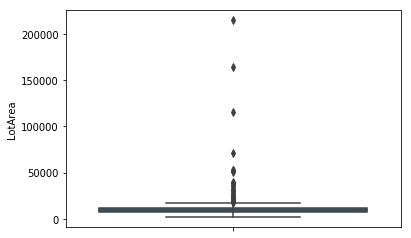

In [4893]:
sb.boxplot(y=train['LotArea'])

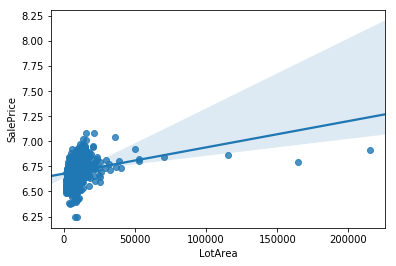

In [4894]:
sb.regplot(y=train['SalePrice'],x=train['LotArea'])

We can observe that there several leverage points. But as the distance from regression line is low we will need to consider 3* mean as the cutoff of cooks' distance and select the minimum from them. 

Highly influential value with c>1: 164660 at index 222
Influential value with c>3*mean: 164660 at index 222
Influential value with c>3*mean: 115149 at index 723
Influential value with c>3*mean: 35760 at index 763
Highly influential value with c>1: 215245 at index 844
Influential value with c>3*mean: 215245 at index 844


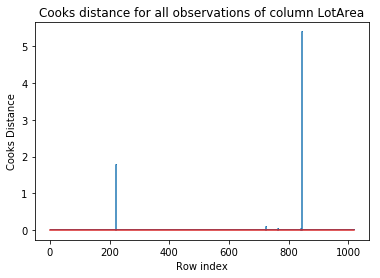

In [4895]:
Ols = sm.OLS(train['SalePrice'],sm.add_constant(train['LotArea'])).fit()
cook_distance(Ols,'LotArea',train['LotArea'])

In [4896]:
LotArea = train[train['LotArea']<35000]['LotArea']
salePrice = train[train['LotArea']<35000]['SalePrice']

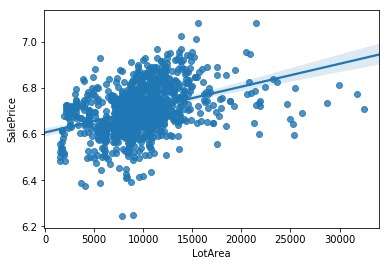

In [4897]:
sb.regplot(x=LotArea,y=salePrice)

In [4898]:
train[train['LotArea']<35000][['SalePrice','LotArea']].corr()

,SalePrice,LotArea
SalePrice,1.000000,0.376473
LotArea,0.376473,1.000000


In [4899]:
train = train[train['LotArea']<35000]

In [4900]:
train['Street'].unique()

array(['Pave', 'Grvl'], dtype=object)

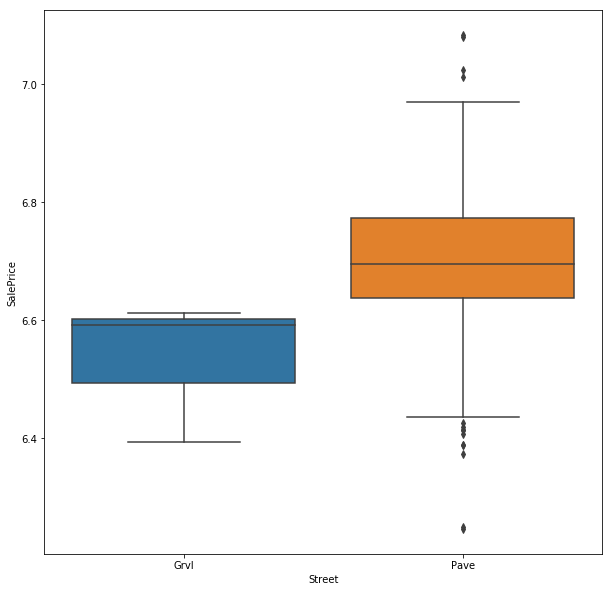

In [4901]:
boxplot_cat('Street')

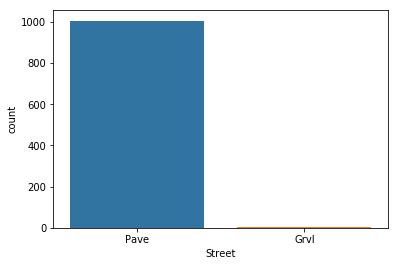

In [4902]:
sb.countplot(train['Street'])

In [4903]:
100*train.groupby('Street')['Id'].count()/len(train)

Street
Grvl     0.297324
Pave    99.702676
Name: Id, dtype: float64

As almost all the datapoints belong to same class we can drop this feature

In [4904]:
train.drop('Street',inplace=True,axis=1)

In [4905]:
print(train['Alley'].unique())
train['Alley'] = train['Alley'].fillna('NA')

[nan 'Grvl' 'Pave']


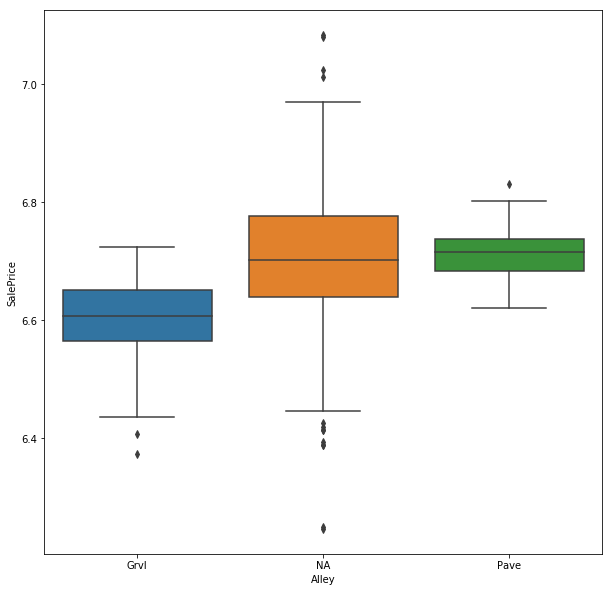

In [4906]:
boxplot_cat('Alley')

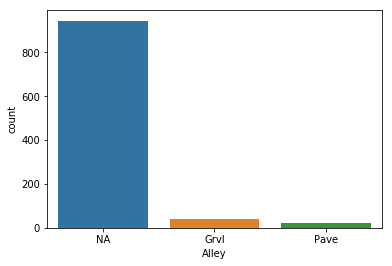

In [4907]:
sb.countplot(train['Alley'])

In [4908]:
train.groupby('Alley')['Id'].count()/len(train)

Alley
Grvl    0.040634
NA      0.936571
Pave    0.022795
Name: Id, dtype: float64

Although most of the values are NA implying absence of alley, we can see that when indeed alley is present houses with paved alleys are markedly more expensive than gravel ones. So, we retain this variable and convert it to dummy.

In [4909]:
train['LotShape'].unique()

array(['Reg', 'IR1', 'IR2', 'IR3'], dtype=object)

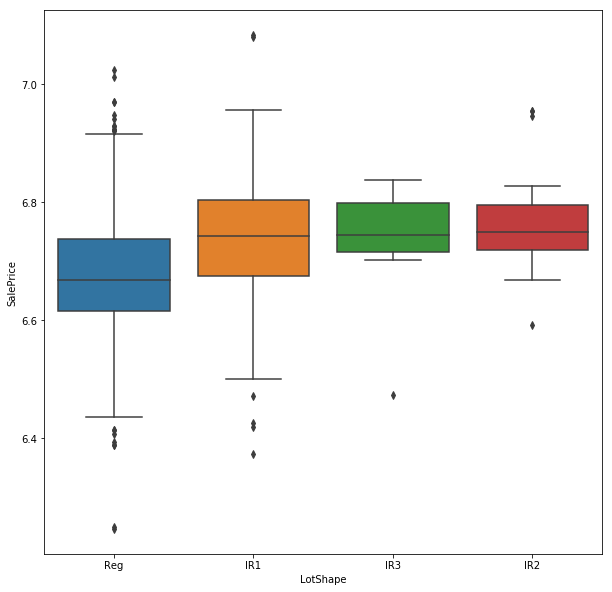

In [4910]:
boxplot_cat('LotShape')

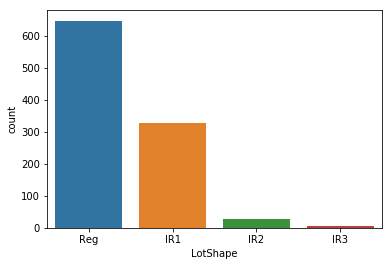

In [4911]:
sb.countplot(train['LotShape'])

Although intuitively Regular shaped plots should be priced higher. But here we see that regular shaped plots are considerably lower priced than irregular ones, and there is almost no difference in prices between the irregular plots.

In [4912]:
train['LandContour'].unique()

array(['Low', 'Lvl', 'Bnk', 'HLS'], dtype=object)

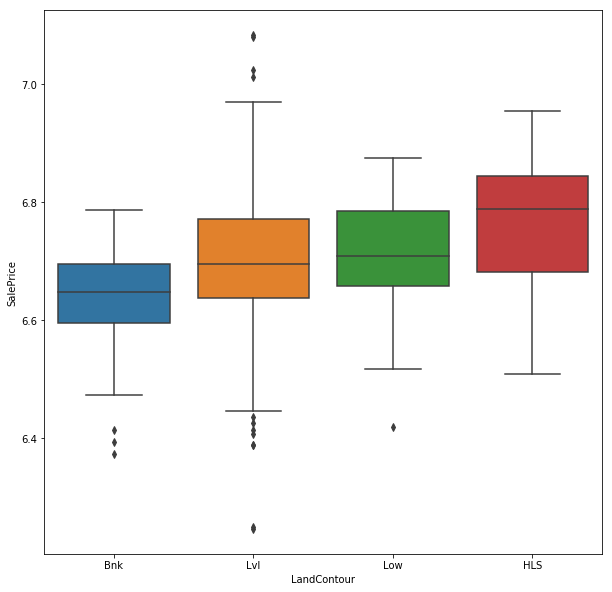

In [4913]:
boxplot_cat('LandContour')

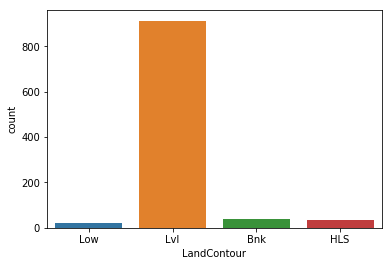

In [4914]:
sb.countplot(train['LandContour'])

In [4915]:
100*train.groupby('LandContour')['Id'].count()/len(train)

LandContour
Bnk     4.063429
HLS     3.369673
Low     2.081269
Lvl    90.485629
Name: Id, dtype: float64

In [4916]:
train['Utilities'].unique()

array(['AllPub', 'NoSeWa'], dtype=object)

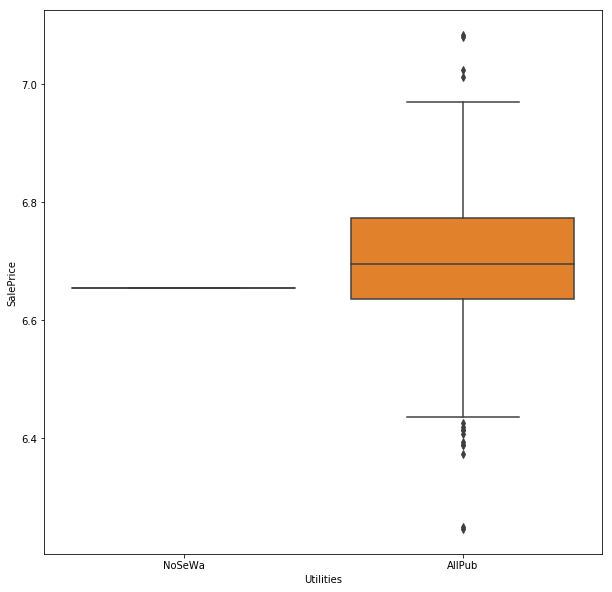

In [4917]:
boxplot_cat('Utilities')

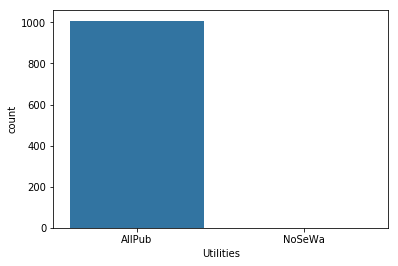

In [4918]:
sb.countplot(train['Utilities'])

Almost all values belong to same class and so we are dropping this column

In [4919]:
train.drop('Utilities',axis=1,inplace=True)

In [4920]:
train['LotConfig'].unique()

array(['Inside', 'Corner', 'FR2', 'CulDSac', 'FR3'], dtype=object)

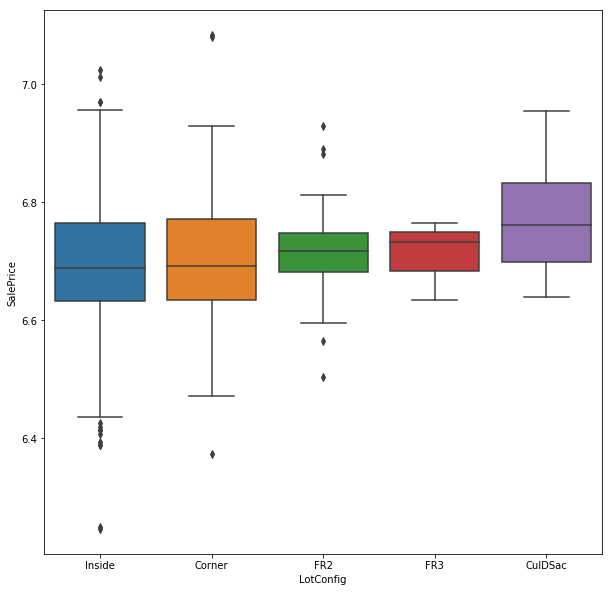

In [4921]:
boxplot_cat('LotConfig')

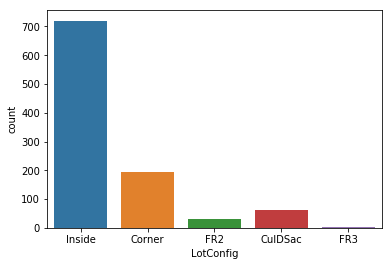

In [4922]:
sb.countplot(train['LotConfig'])

Not much variation in price is seen across various LotConfig classes.So, we can drop this columns.

In [4923]:
train.drop('LotConfig',axis=1,inplace=True)

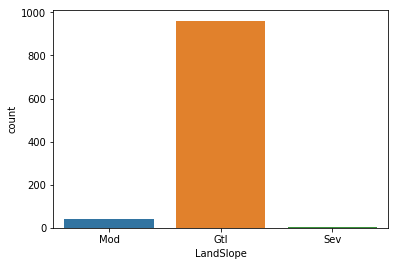

In [4924]:
sb.countplot(train['LandSlope'])

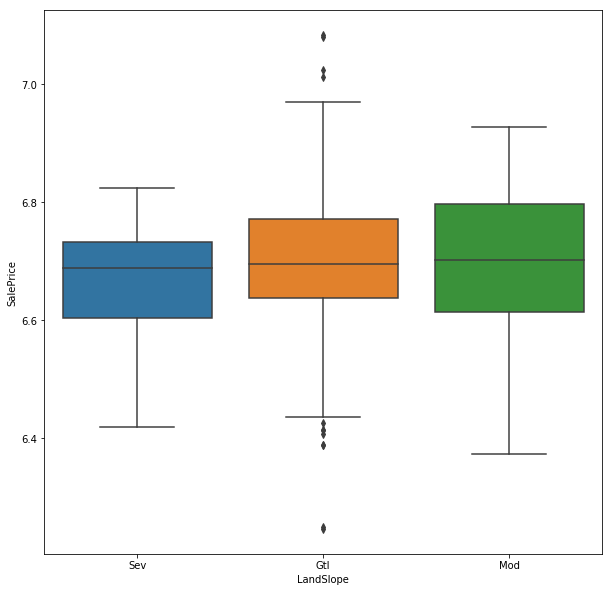

In [4925]:
boxplot_cat('LandSlope')

Again we see that not much variation across prices is seen for land slope, thus we drop it.

In [4926]:
train.drop('LandSlope',axis=1,inplace=True)

In [4927]:
train['Neighborhood'].unique()

array(['NoRidge', 'Edwards', 'OldTown', 'CollgCr', 'SawyerW', 'NAmes',
       'Crawfor', 'IDOTRR', 'NWAmes', 'NridgHt', 'SWISU', 'Timber',
       'BrkSide', 'Somerst', 'MeadowV', 'Sawyer', 'Mitchel', 'Veenker',
       'Gilbert', 'BrDale', 'NPkVill', 'StoneBr', 'Blmngtn', 'ClearCr',
       'Blueste'], dtype=object)

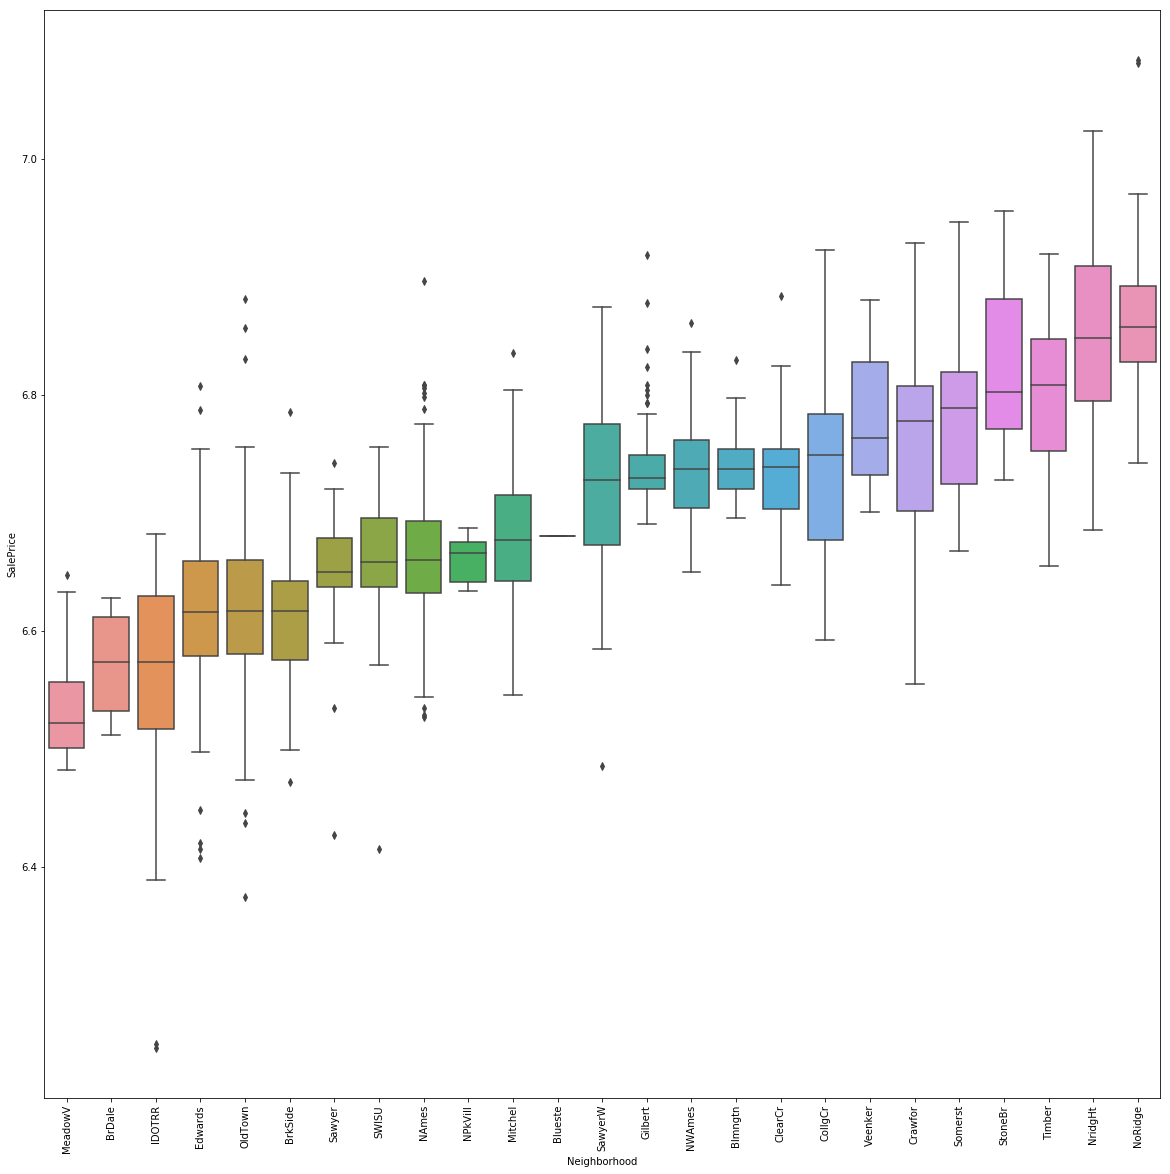

In [4928]:
boxplot_cat('Neighborhood',(20,20),90)

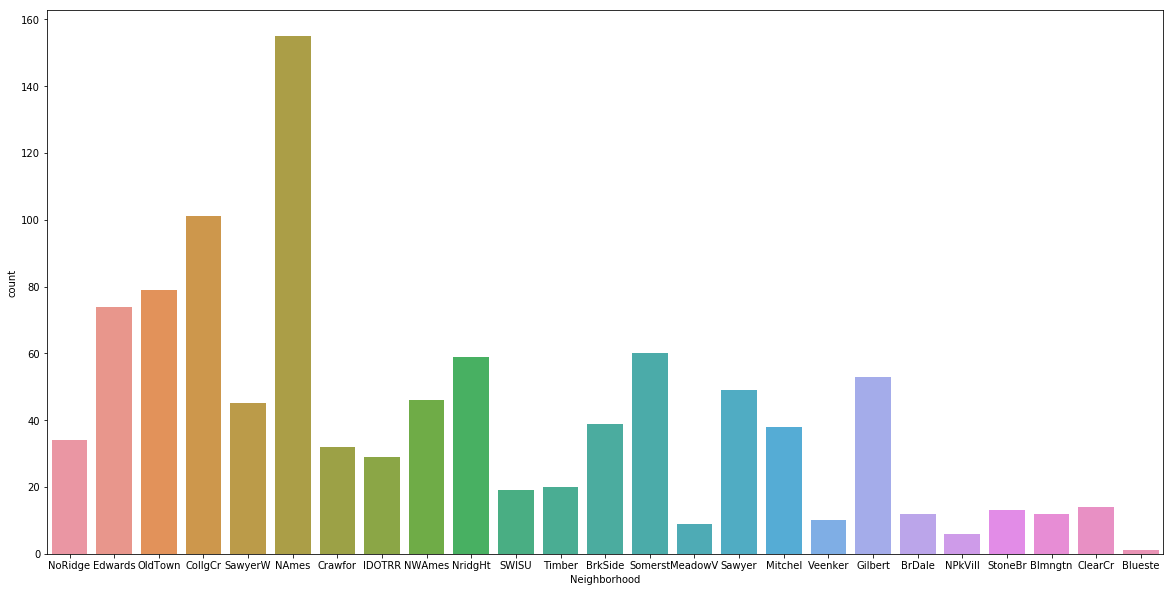

In [4929]:
plt.figure(figsize=(20,10))
sb.countplot(train['Neighborhood'])

We observe a very strong trend in price with locality

In [4930]:
train['Condition1'].unique()

array(['Norm', 'Feedr', 'Artery', 'RRAn', 'RRNn', 'PosN', 'RRAe', 'PosA',
       'RRNe'], dtype=object)

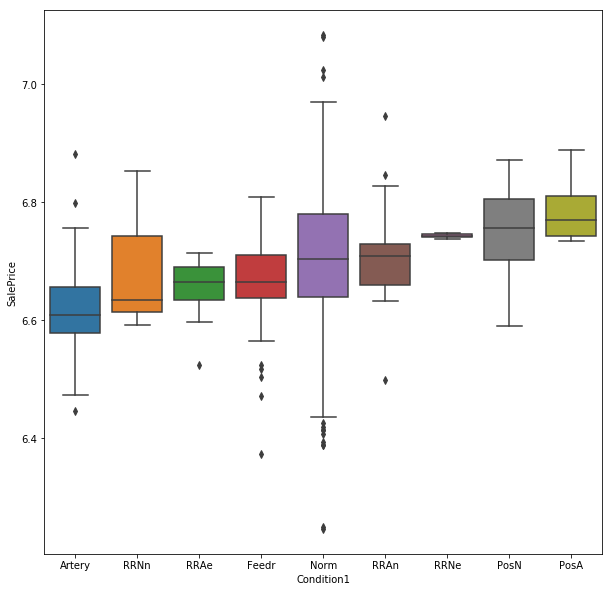

In [4931]:
boxplot_cat('Condition1')

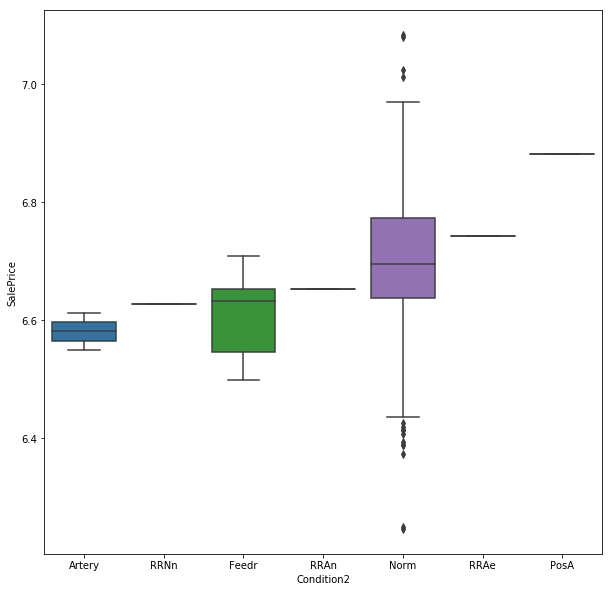

In [4932]:
boxplot_cat('Condition2')

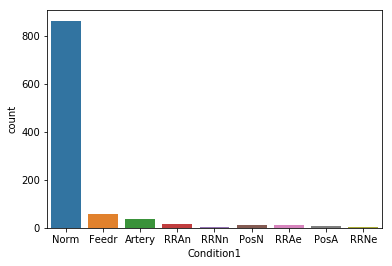

In [4933]:
sb.countplot(train['Condition1'])

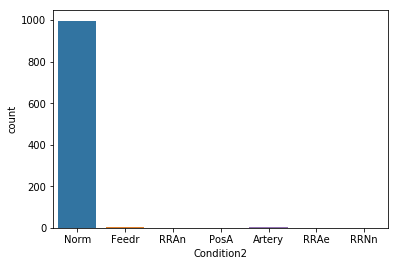

In [4934]:
sb.countplot(train['Condition2'])

In [4935]:
group_count('Condition1')

Condition1
Artery     3.766105
Feedr      5.550050
Norm      85.530228
PosA       0.594648
PosN       1.288404
RRAe       1.090188
RRAn       1.684836
RRNe       0.198216
RRNn       0.297324
Name: Id, dtype: float64


In [4936]:
group_count('Condition2')

Condition2
Artery     0.198216
Feedr      0.594648
Norm      98.810704
PosA       0.099108
RRAe       0.099108
RRAn       0.099108
RRNn       0.099108
Name: Id, dtype: float64


In [4937]:
train.drop('Condition2',inplace=True,axis=1)

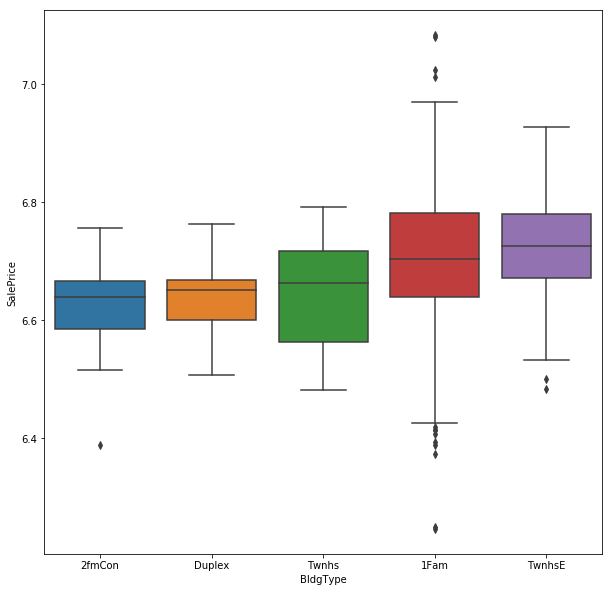

In [4938]:
boxplot_cat('BldgType')

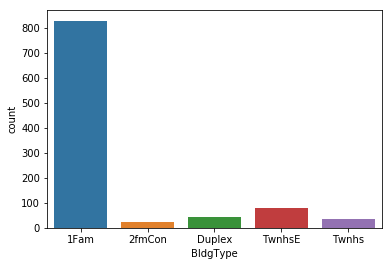

In [4939]:
sb.countplot(train['BldgType'])

In [4940]:
group_count('BldgType')

BldgType
1Fam      82.061447
2fmCon     2.378593
Duplex     4.162537
Twnhs      3.567889
TwnhsE     7.829534
Name: Id, dtype: float64


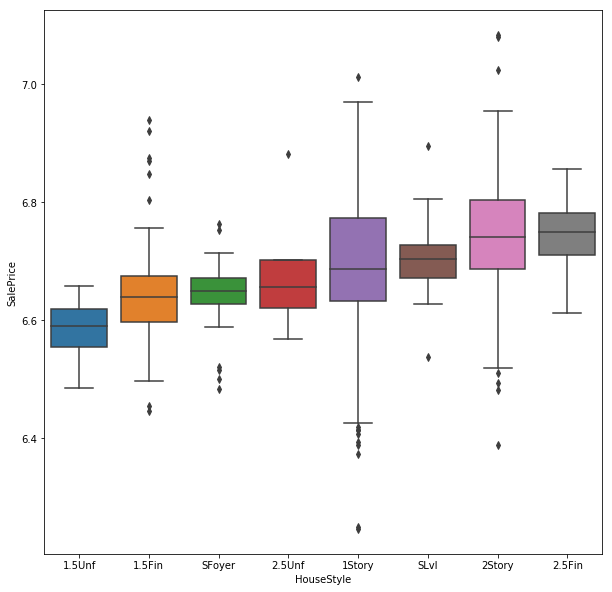

In [4941]:
boxplot_cat('HouseStyle')

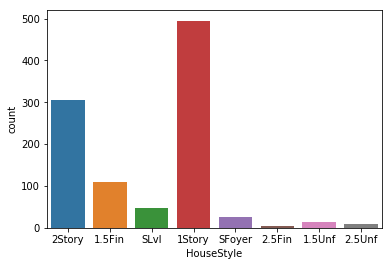

In [4942]:
sb.countplot(train['HouseStyle'])

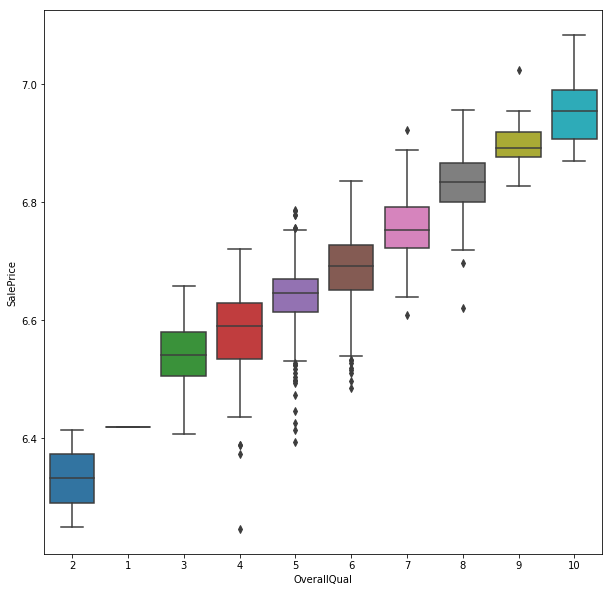

In [4943]:
boxplot_cat('OverallQual')

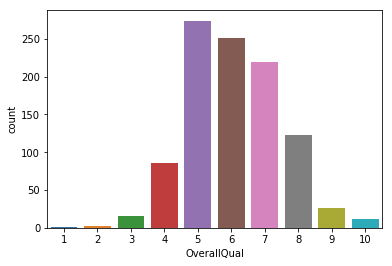

In [4944]:
sb.countplot(train['OverallQual'])

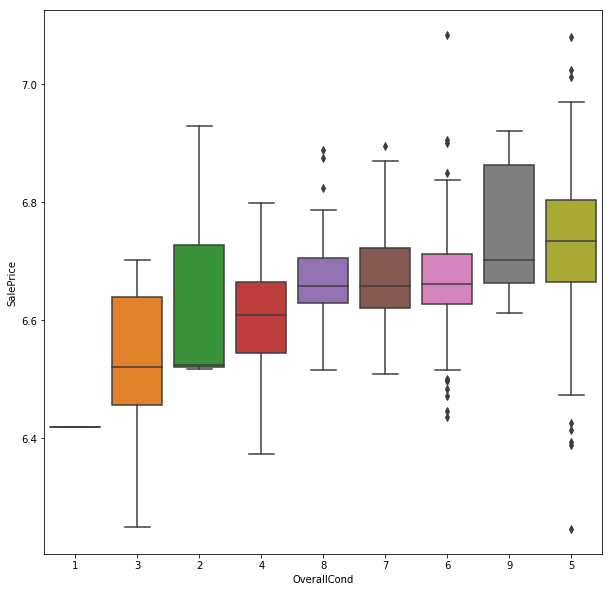

In [4945]:
boxplot_cat('OverallCond')

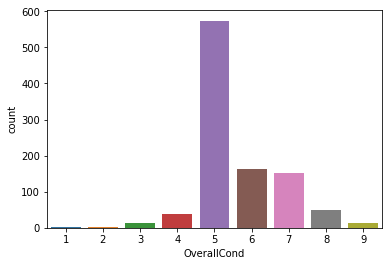

In [4946]:
sb.countplot(train['OverallCond'])

In [4947]:
train['YearRemodAdd'].unique()

array([1993, 1950, 2003, 1977, 2009, 2002, 1985, 1997, 1953, 1996, 1976,
       2007, 1982, 1980, 1959, 1958, 1966, 2006, 2004, 1972, 2005, 1984,
       2000, 1995, 1963, 1951, 1998, 1962, 1969, 2008, 2001, 1970, 1999,
       1990, 1964, 1994, 1988, 1978, 1973, 1967, 1960, 1956, 1992, 1991,
       1954, 1952, 1979, 1987, 1974, 1989, 2010, 1957, 1961, 1981, 1968,
       1965, 1975, 1971, 1983, 1986, 1955], dtype=int64)

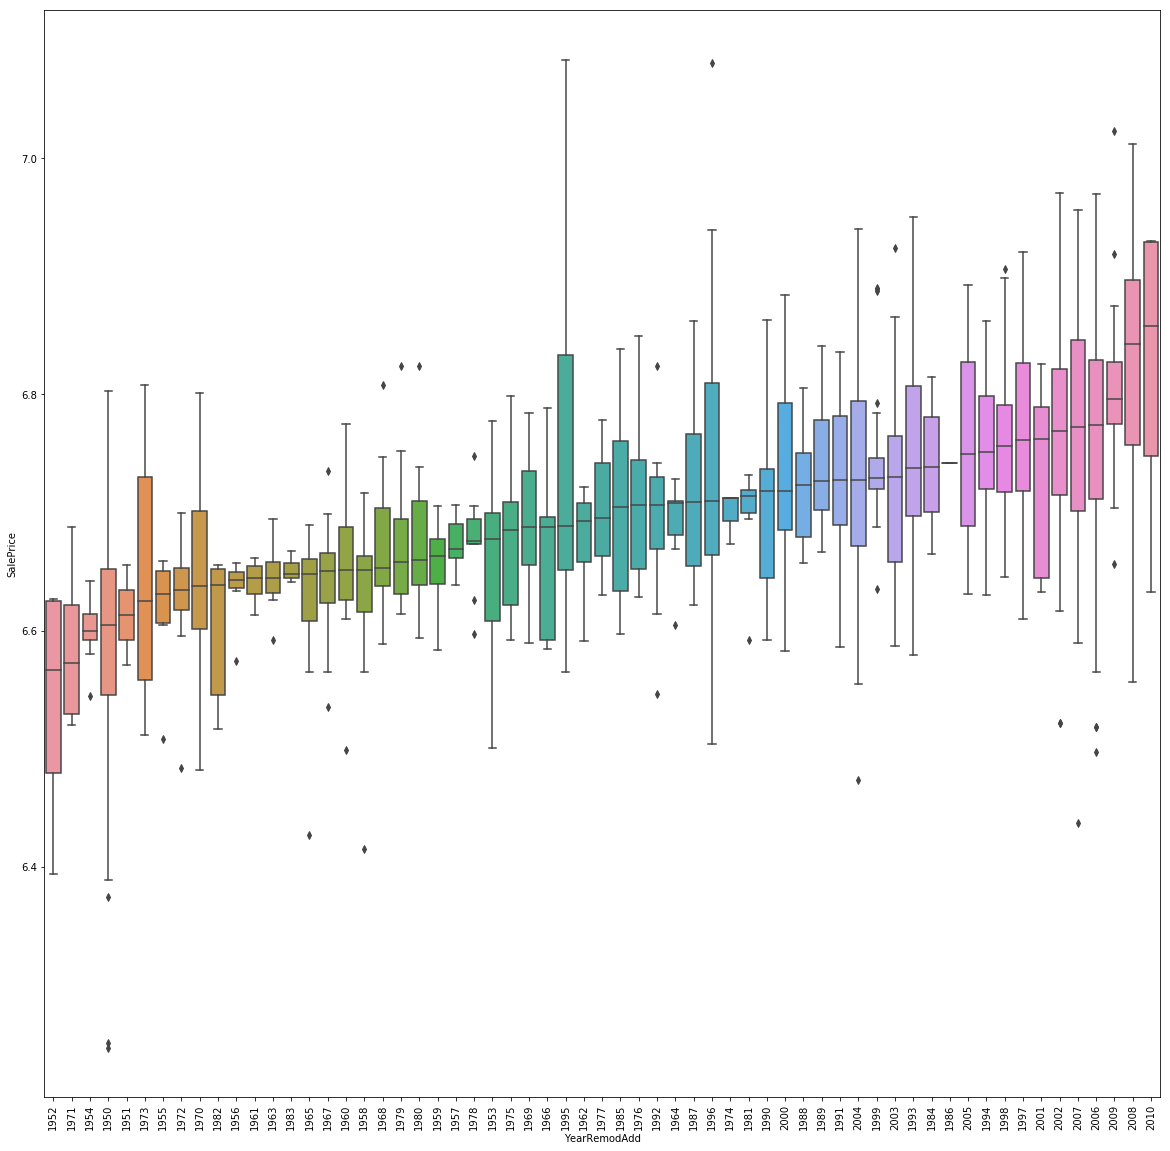

In [4948]:
boxplot_cat('YearRemodAdd',size=(20,20),rot=90)

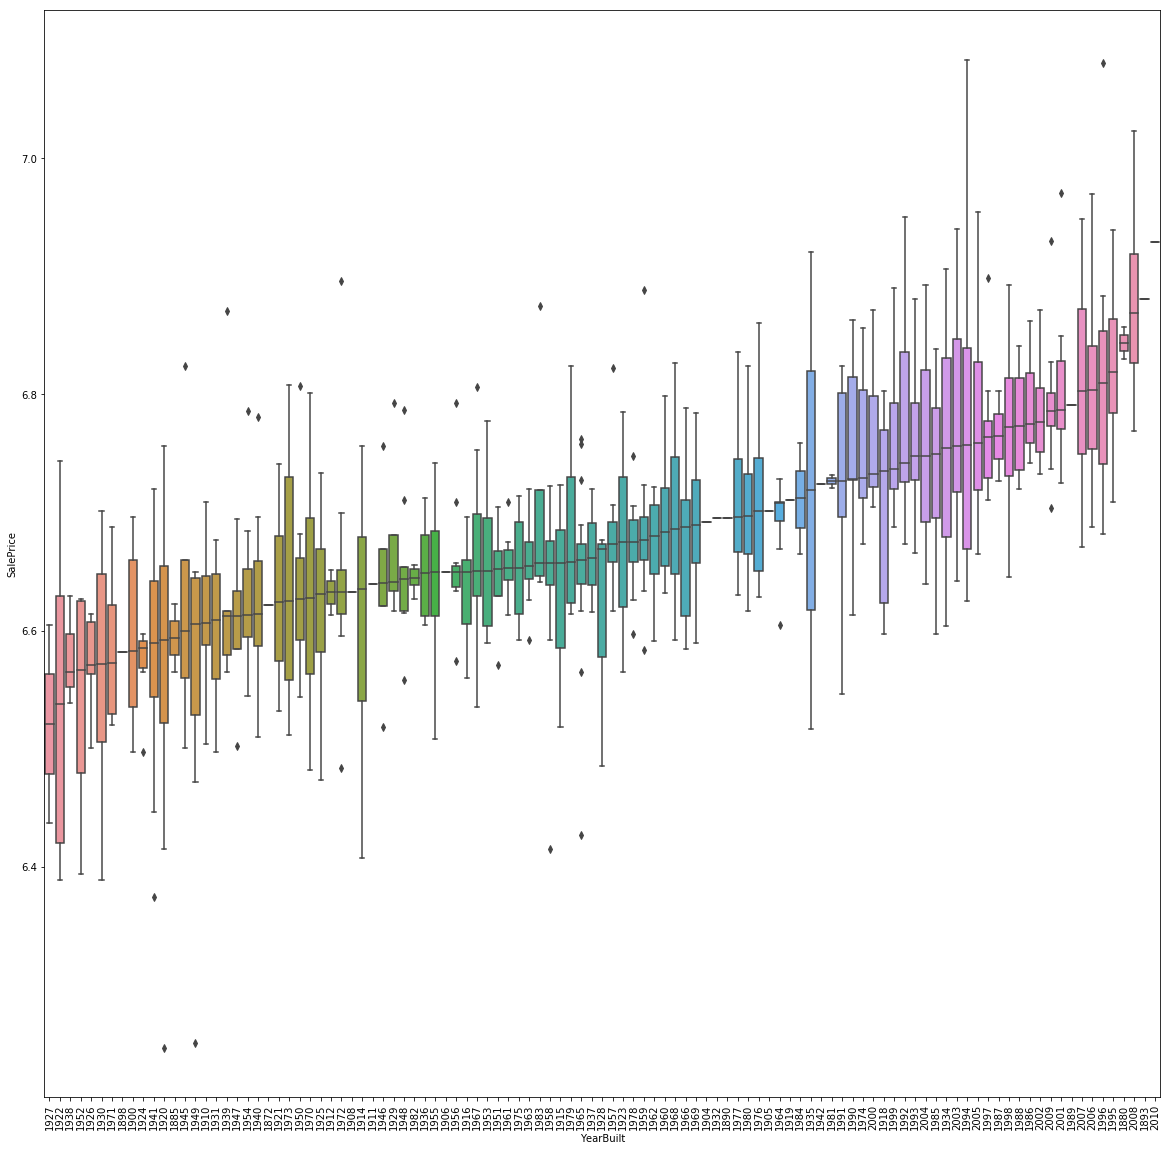

In [4949]:
boxplot_cat('YearBuilt',size=(20,20),rot=90)

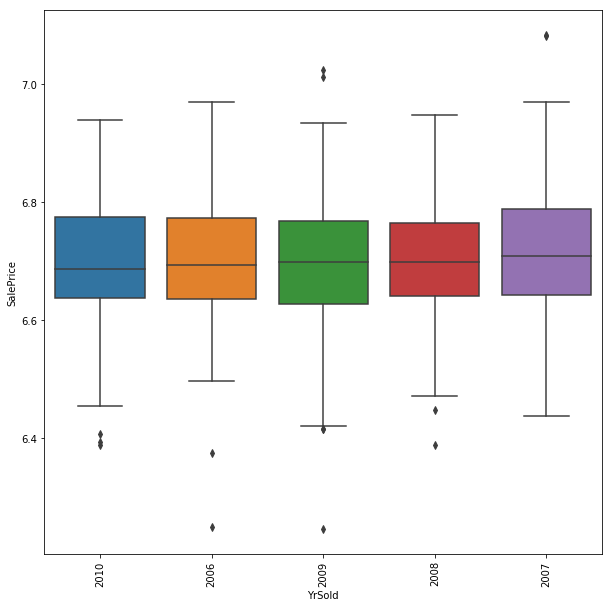

In [4950]:
boxplot_cat('YrSold',rot=90)

In [4951]:
#deriving new features age and remodel_age (depicting years since remodeled)
train['age'] = train['YrSold']-train['YearBuilt']
train['remodel_age'] = train['YrSold'] - train['YearRemodAdd']

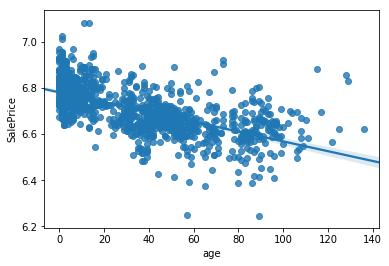

In [4952]:
sb.regplot(x=train['age'],y=train['SalePrice'])

In [4953]:
train[['age','SalePrice']].corr()

,age,SalePrice
age,1.000000,-0.609023
SalePrice,-0.609023,1.000000


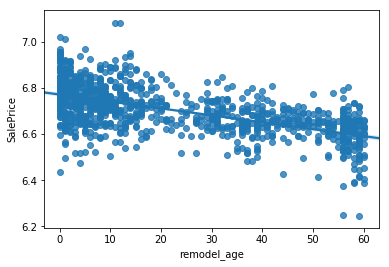

In [4954]:
sb.regplot(x=train['remodel_age'],y=train['SalePrice'])

In [4955]:
train[['remodel_age','SalePrice']].corr()

,remodel_age,SalePrice
remodel_age,1.000000,-0.583615
SalePrice,-0.583615,1.000000


In [4956]:
train[['age','remodel_age']].corr()

,age,remodel_age
age,1.000000,0.593413
remodel_age,0.593413,1.000000


In [4957]:
train.drop(['YrSold','YearBuilt','YearRemodAdd'],axis=1,inplace=True)

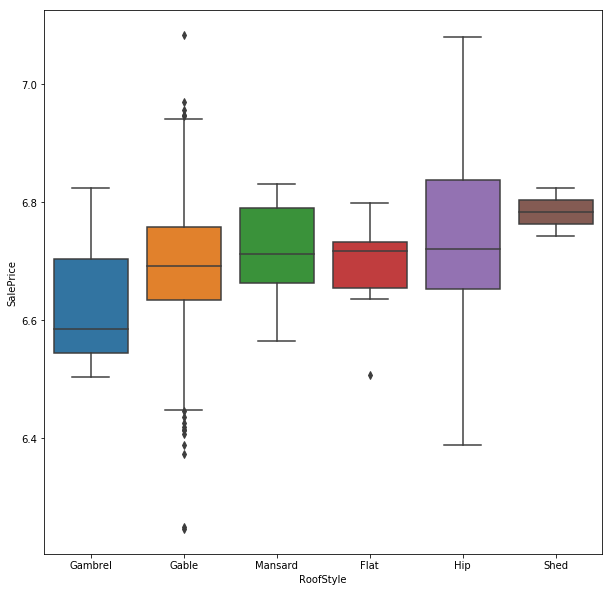

In [4958]:
boxplot_cat('RoofStyle')

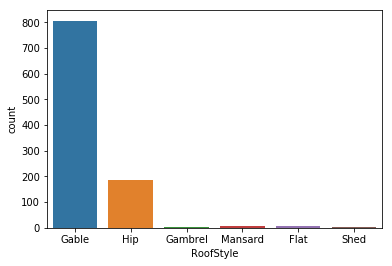

In [4959]:
sb.countplot(train['RoofStyle'])

In [4960]:
group_count('RoofStyle')

RoofStyle
Flat        0.594648
Gable      79.881070
Gambrel     0.297324
Hip        18.434093
Mansard     0.594648
Shed        0.198216
Name: Id, dtype: float64


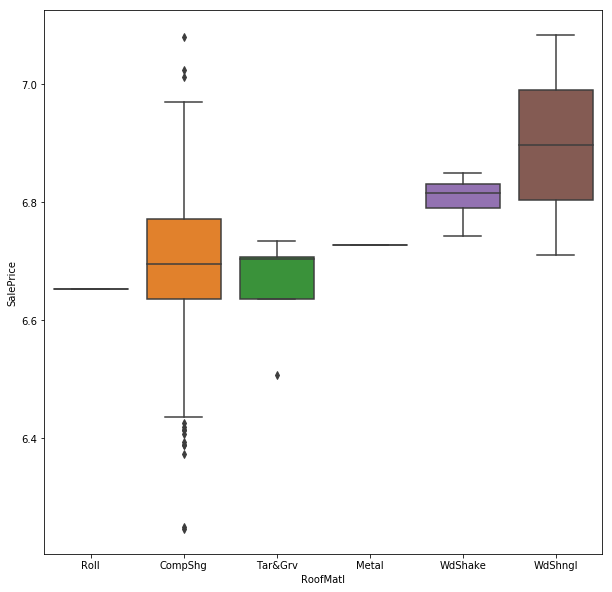

In [4961]:
boxplot_cat('RoofMatl')

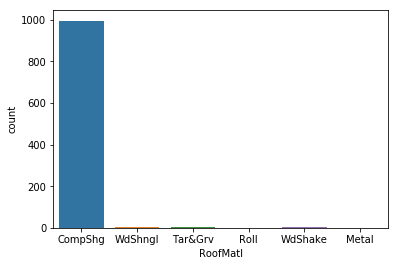

In [4962]:
sb.countplot(train['RoofMatl'])

In [4963]:
group_count('RoofMatl')

RoofMatl
CompShg    98.711596
Metal       0.099108
Roll        0.099108
Tar&Grv     0.495540
WdShake     0.396432
WdShngl     0.198216
Name: Id, dtype: float64


In [4964]:
train.drop('RoofMatl',axis=1,inplace=True)

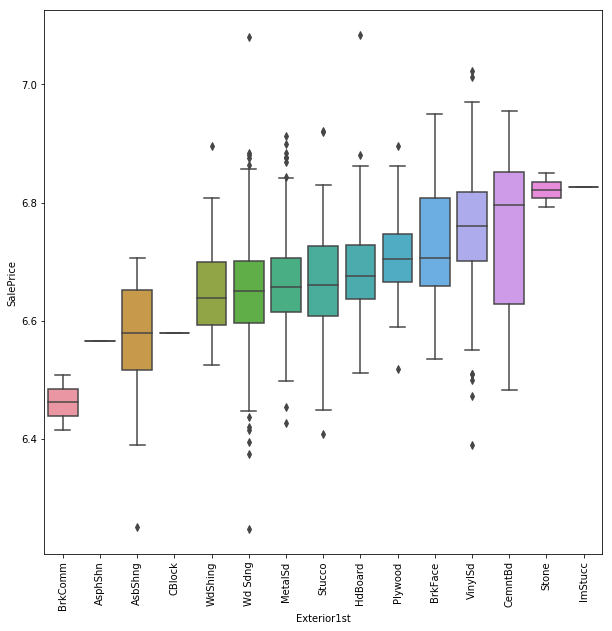

In [4965]:
boxplot_cat('Exterior1st',rot=90)

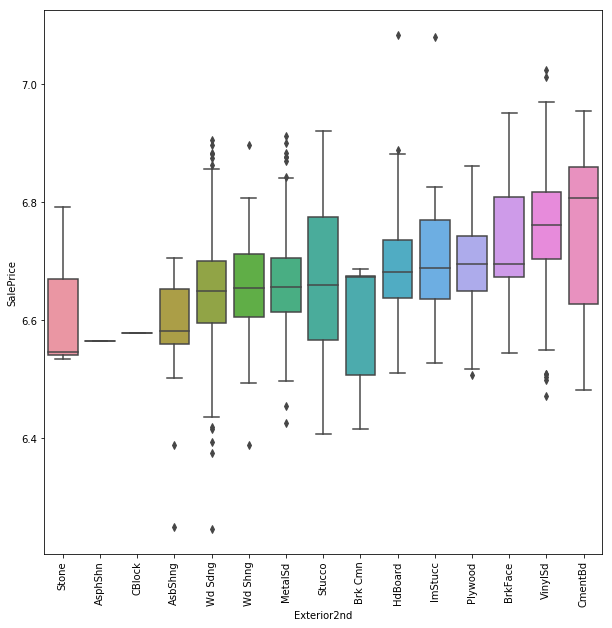

In [4966]:
boxplot_cat('Exterior2nd',rot=90)

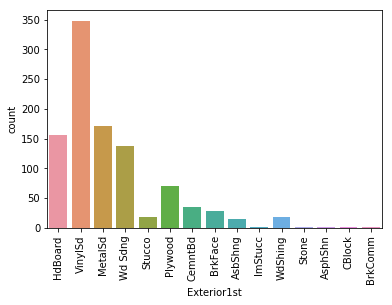

In [4967]:
plt.xticks(rotation=90)
sb.countplot(train['Exterior1st'])

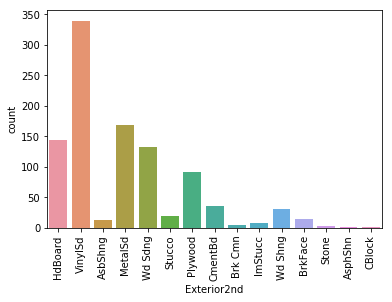

In [4968]:
plt.xticks(rotation=90)
sb.countplot(train['Exterior2nd'])

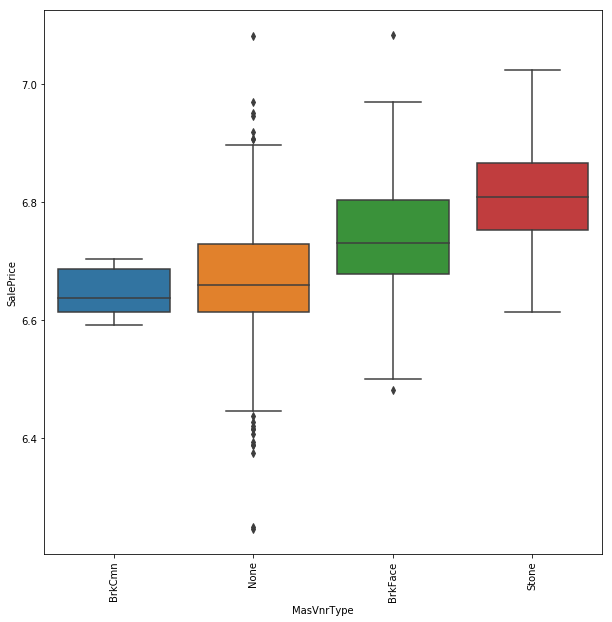

In [4969]:
# the null values are filled with None as seen from the data dictionary
train['MasVnrType'].fillna('None',inplace=True)
boxplot_cat('MasVnrType',rot=90)

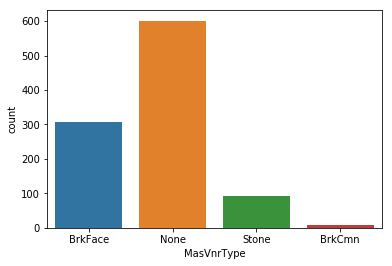

In [4970]:
sb.countplot(train['MasVnrType'])

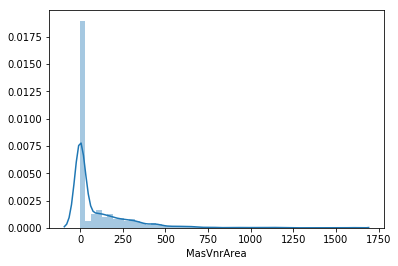

In [4971]:
sb.distplot(train[~train['MasVnrArea'].isna()]['MasVnrArea'])

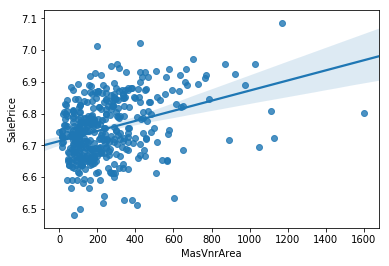

In [4972]:
sb.regplot(x=train[train['MasVnrArea']!=0]['MasVnrArea'],y=train[train['MasVnrArea']!=0]['SalePrice'])

In [4973]:
train[train['MasVnrArea']!=0][['MasVnrArea','SalePrice']].corr()

,MasVnrArea,SalePrice
MasVnrArea,1.00000,0.34161
SalePrice,0.34161,1.00000


In [4974]:
100*len(train[train['MasVnrArea']!=0])/len(train)

40.93161546085233

In [4975]:
train['MasVnrArea'] = train.apply(lambda x: 0 if np.isnan(x['MasVnrArea']) else x['MasVnrArea'],axis=1)

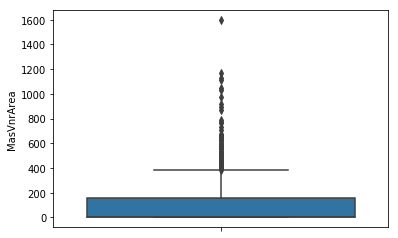

In [4976]:
sb.boxplot(y=train['MasVnrArea'])

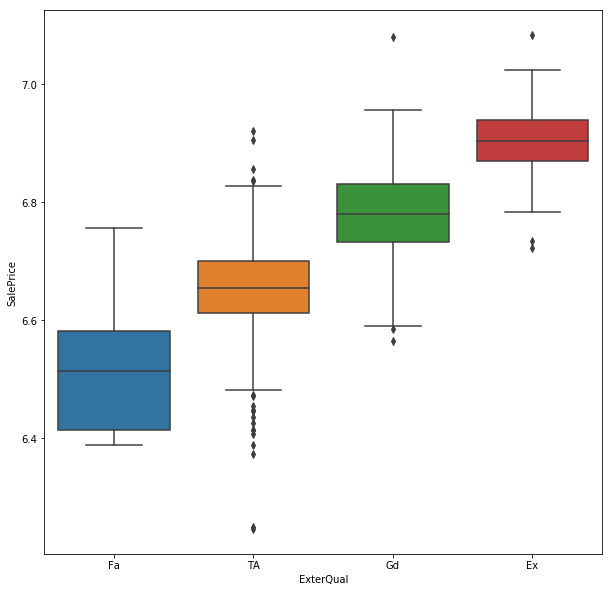

In [4977]:
boxplot_cat('ExterQual')

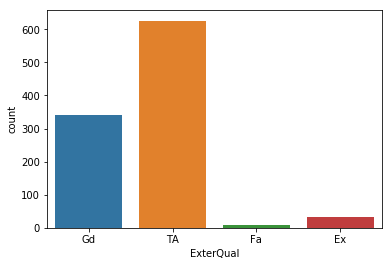

In [4978]:
sb.countplot(train['ExterQual'])

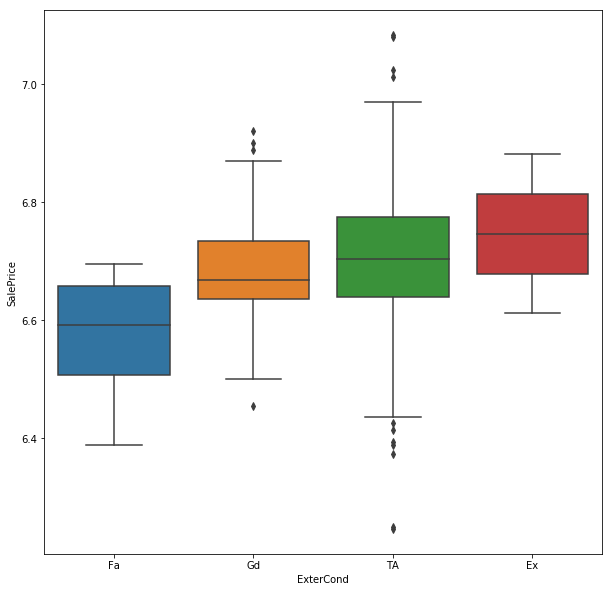

In [4979]:
boxplot_cat('ExterCond')

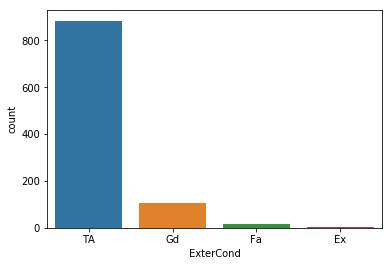

In [4980]:
sb.countplot(train['ExterCond'])

In [4981]:
group_count('ExterCond')

ExterCond
Ex     0.198216
Fa     1.783944
Gd    10.406343
TA    87.611497
Name: Id, dtype: float64


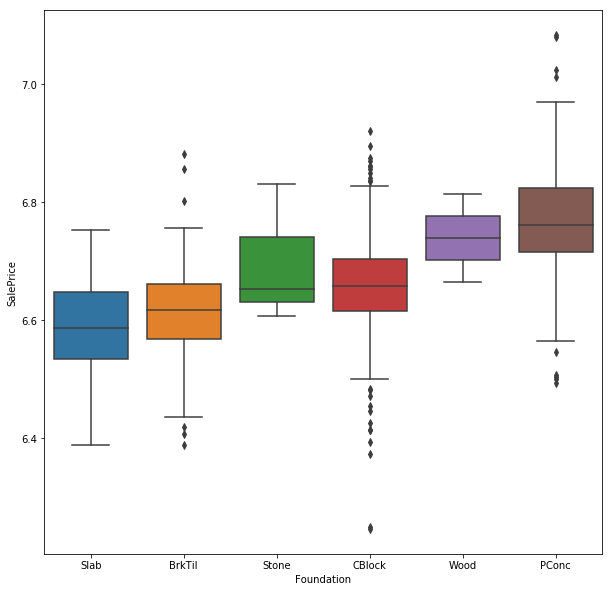

In [4982]:
boxplot_cat('Foundation')

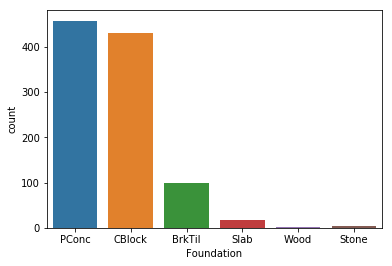

In [4983]:
sb.countplot(train['Foundation'])

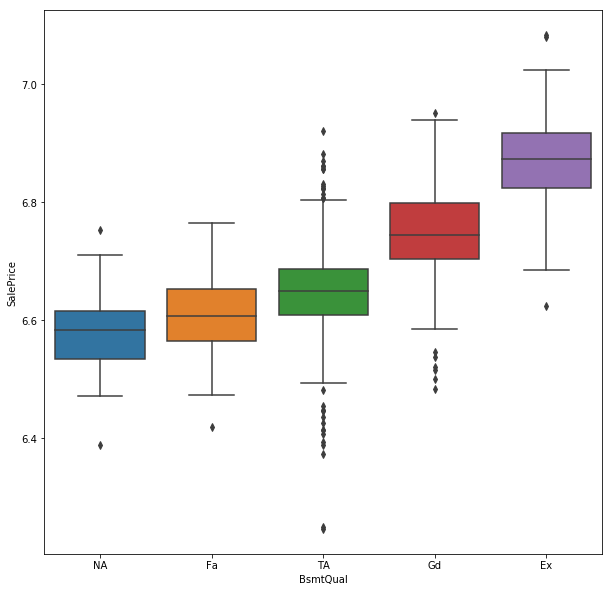

In [4984]:
train['BsmtQual'].fillna('NA',inplace=True)
boxplot_cat('BsmtQual')

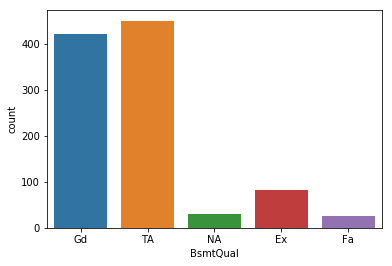

In [4985]:
sb.countplot(train['BsmtQual'])

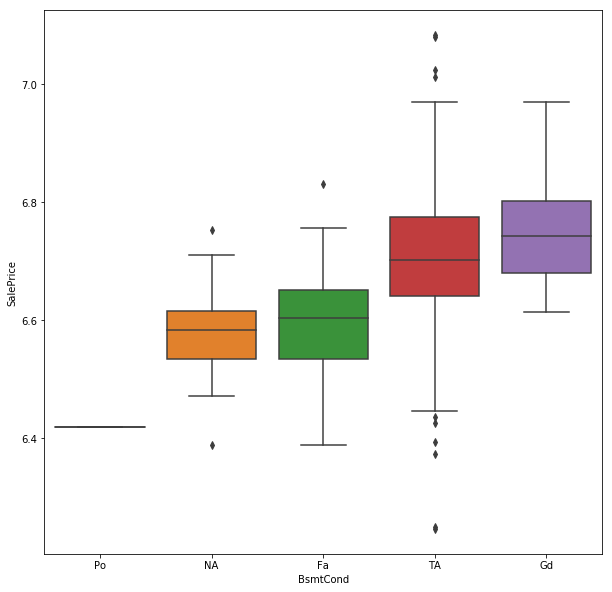

In [4986]:
train['BsmtCond'].fillna('NA',inplace=True)
boxplot_cat('BsmtCond')

In [4987]:
group_count('BsmtCond')

BsmtCond
Fa     3.171457
Gd     4.757185
NA     2.874133
Po     0.099108
TA    89.098117
Name: Id, dtype: float64


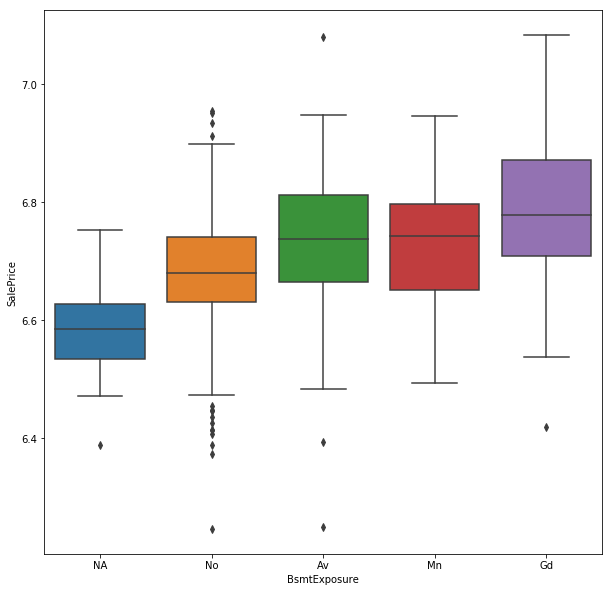

In [4988]:
train['BsmtExposure'].fillna('NA',inplace=True)
boxplot_cat('BsmtExposure')

In [4989]:
group_count('BsmtExposure')

BsmtExposure
Av    15.659068
Gd     9.018831
Mn     8.225966
NA     2.973241
No    64.122894
Name: Id, dtype: float64


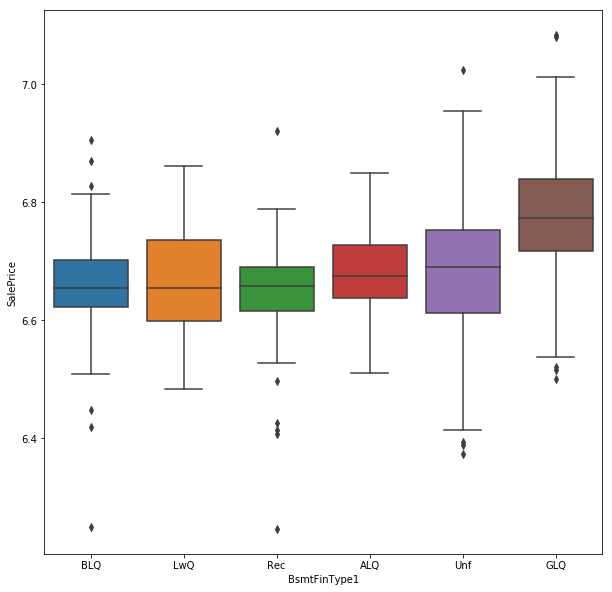

In [4990]:
boxplot_cat('BsmtFinType1')

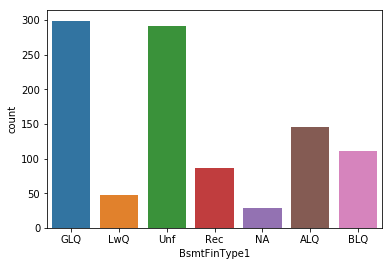

In [4991]:
train['BsmtFinType1'].fillna('NA',inplace=True)
sb.countplot(train['BsmtFinType1'])

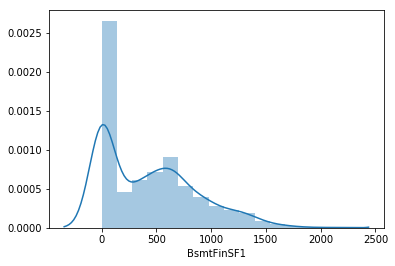

In [4992]:
sb.distplot(train['BsmtFinSF1'])

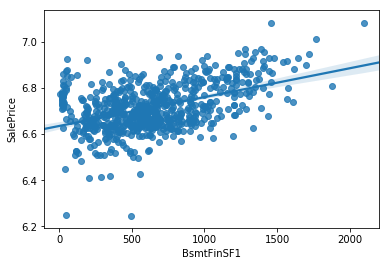

In [4993]:
sb.regplot(x=train[train['BsmtFinSF1']!=0]['BsmtFinSF1'],y=train[train['BsmtFinSF1']!=0]['SalePrice'])

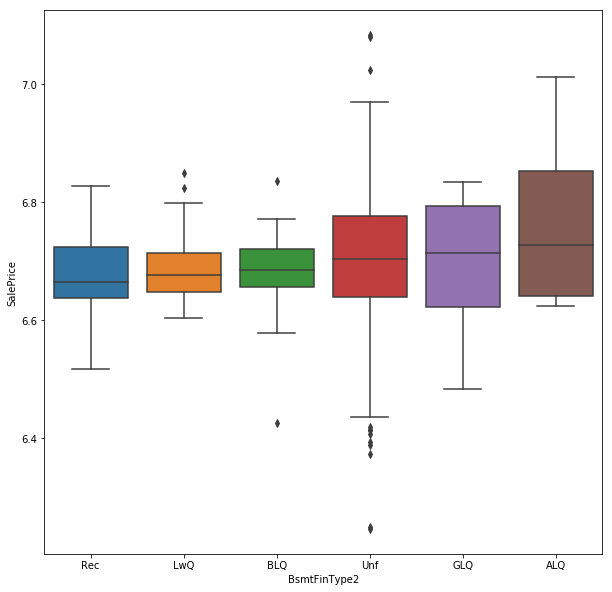

In [4994]:
boxplot_cat('BsmtFinType2')

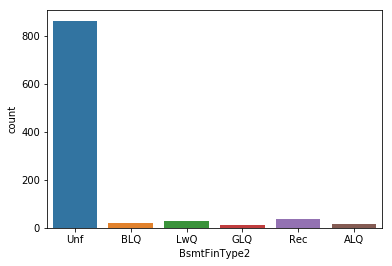

In [4995]:
sb.countplot(train['BsmtFinType2'])

In [4996]:
group_count('BsmtFinType2')

BsmtFinType2
ALQ     1.585728
BLQ     2.180377
GLQ     1.189296
LwQ     2.973241
Rec     3.468781
Unf    85.629336
Name: Id, dtype: float64


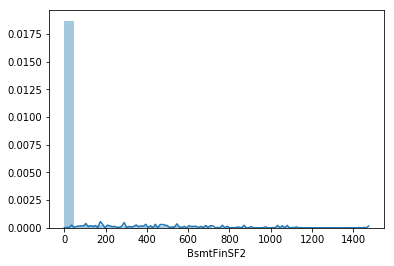

In [4997]:
sb.distplot(train['BsmtFinSF2'])

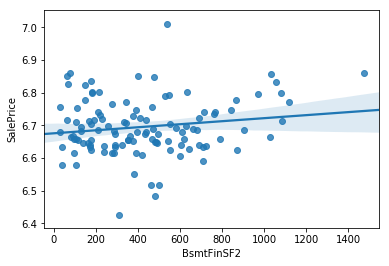

In [4998]:
sb.regplot(x=train[train['BsmtFinSF2']!=0]['BsmtFinSF2'],y=train[train['BsmtFinSF2']!=0]['SalePrice'])

In [4999]:
train.drop('BsmtFinType2',axis=1,inplace=True)

In [5000]:
train.drop('BsmtFinSF2',axis=1,inplace=True)

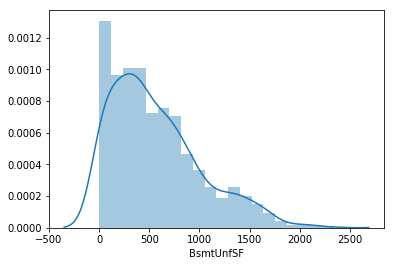

In [5001]:
sb.distplot(train['BsmtUnfSF'])

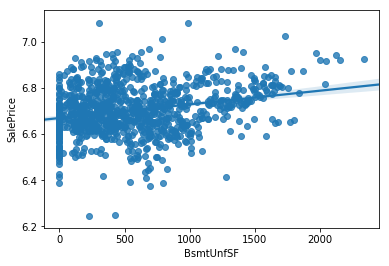

In [5002]:
sb.regplot(x=train['BsmtUnfSF'],y=train['SalePrice'])

In [5003]:
train[['BsmtUnfSF','SalePrice']].corr()

,BsmtUnfSF,SalePrice
BsmtUnfSF,1.00000,0.25097
SalePrice,0.25097,1.00000


In [5004]:
train.drop('BsmtUnfSF',axis=1,inplace=True)

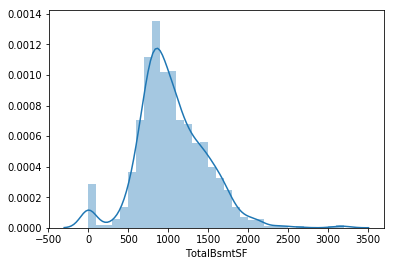

In [5005]:
sb.distplot(train['TotalBsmtSF'])

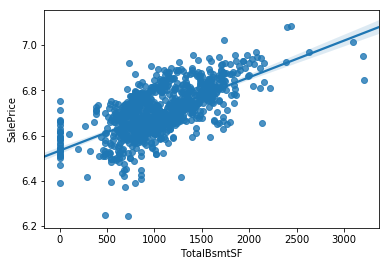

In [5006]:
sb.regplot(x=train['TotalBsmtSF'],y=train['SalePrice'])

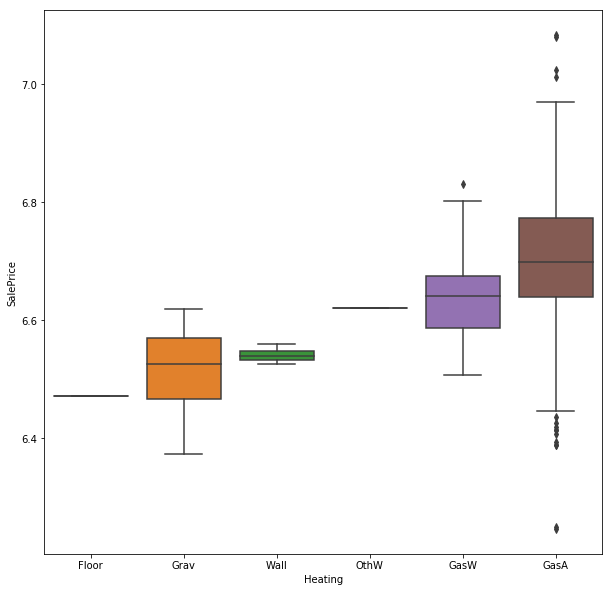

In [5007]:
boxplot_cat('Heating')

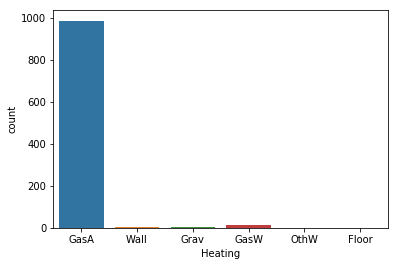

In [5008]:
sb.countplot(train['Heating'])

In [5009]:
group_count('Heating')

Heating
Floor     0.099108
GasA     97.819623
GasW      1.189296
Grav      0.396432
OthW      0.099108
Wall      0.396432
Name: Id, dtype: float64


In [5010]:
train.drop('Heating',axis=1,inplace=True)

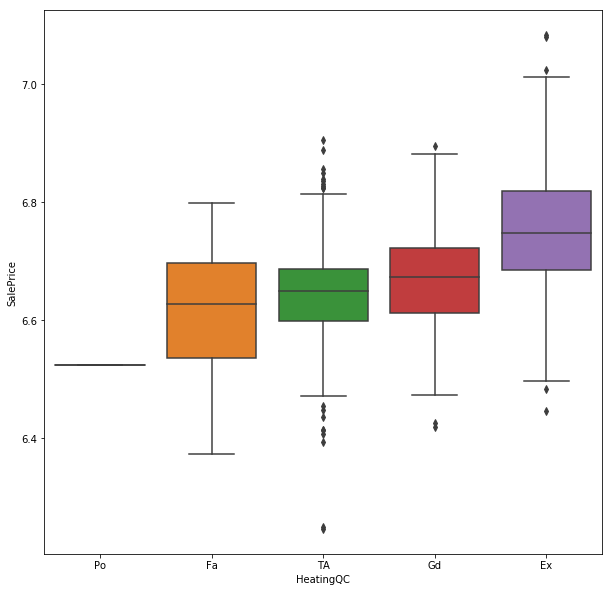

In [5011]:
boxplot_cat('HeatingQC')

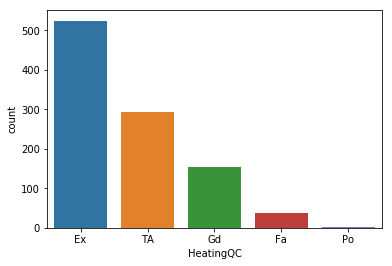

In [5012]:
sb.countplot(train['HeatingQC'])

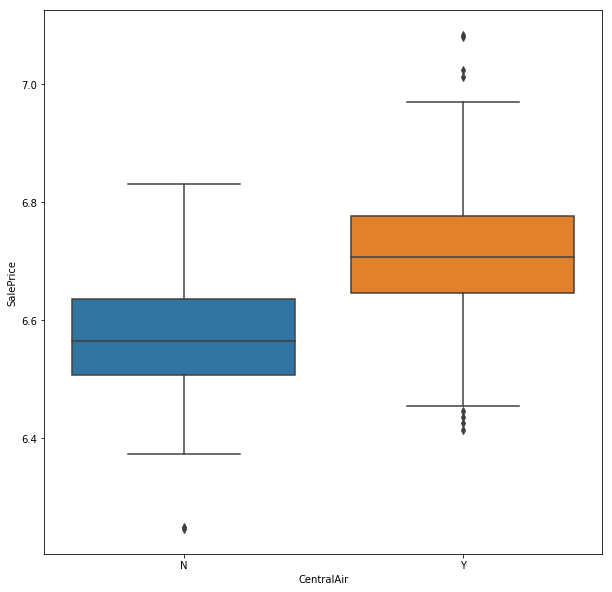

In [5013]:
boxplot_cat('CentralAir')

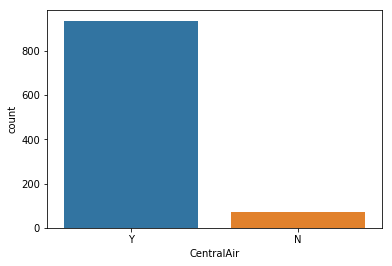

In [5014]:
sb.countplot(train['CentralAir'])

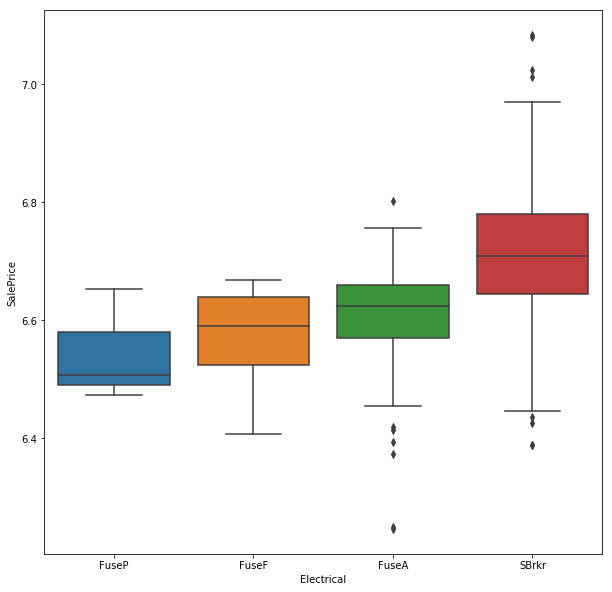

In [5015]:
boxplot_cat('Electrical')

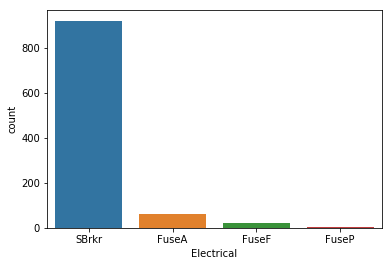

In [5016]:
sb.countplot(train['Electrical'])

In [5017]:
group_count('Electrical')

Electrical
FuseA     6.243806
FuseF     2.081269
FuseP     0.297324
SBrkr    91.377602
Name: Id, dtype: float64


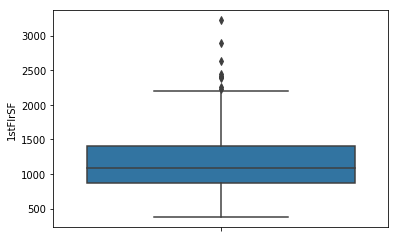

In [5018]:
sb.boxplot(y=train['1stFlrSF'])

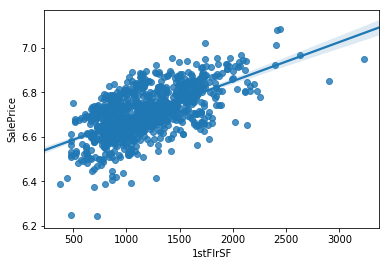

In [5019]:
sb.regplot(x=train['1stFlrSF'],y=train['SalePrice'])

In [5020]:
train[['1stFlrSF','SalePrice']].corr()

,1stFlrSF,SalePrice
1stFlrSF,1.00000,0.62048
SalePrice,0.62048,1.00000


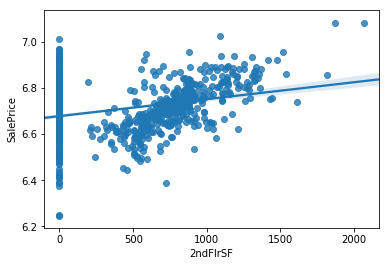

In [5021]:
sb.regplot(x=train['2ndFlrSF'],y=train['SalePrice'])

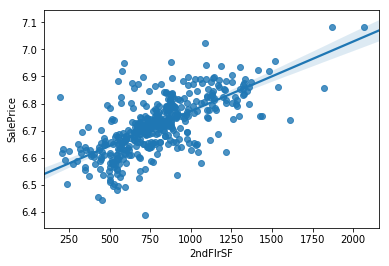

In [5022]:
sb.regplot(x=train[train['2ndFlrSF']!=0]['2ndFlrSF'],y=train[train['2ndFlrSF']!=0]['SalePrice'])

In [5023]:
train[train['2ndFlrSF']!=0][['2ndFlrSF','SalePrice']].corr()

,2ndFlrSF,SalePrice
2ndFlrSF,1.000000,0.678609
SalePrice,0.678609,1.000000


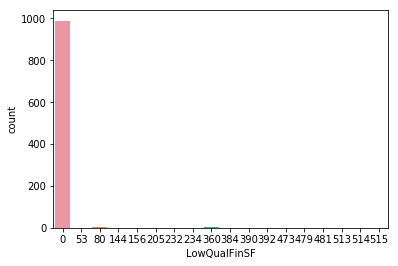

In [5024]:
sb.countplot(train['LowQualFinSF'])

In [5025]:
train.drop('LowQualFinSF',axis=1,inplace=True)

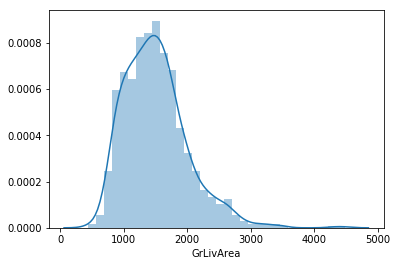

In [5026]:
sb.distplot(train['GrLivArea'])

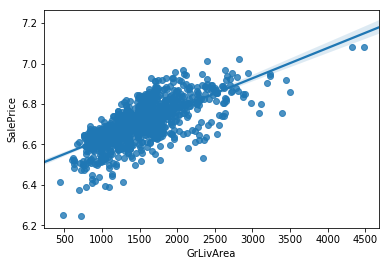

In [5027]:
sb.regplot(x=train['GrLivArea'],y=train['SalePrice'])

In [5028]:
train[['GrLivArea','SalePrice']].corr()

,GrLivArea,SalePrice
GrLivArea,1.000000,0.711776
SalePrice,0.711776,1.000000


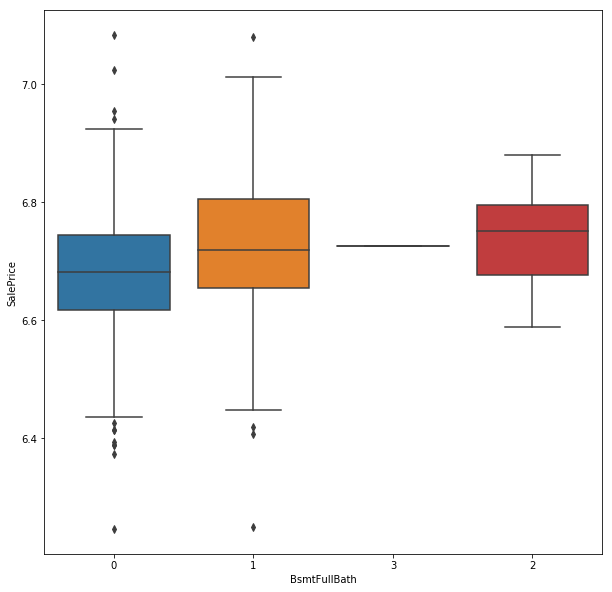

In [5029]:
boxplot_cat('BsmtFullBath')

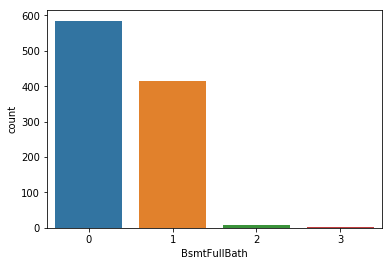

In [5030]:
sb.countplot(train['BsmtFullBath'])

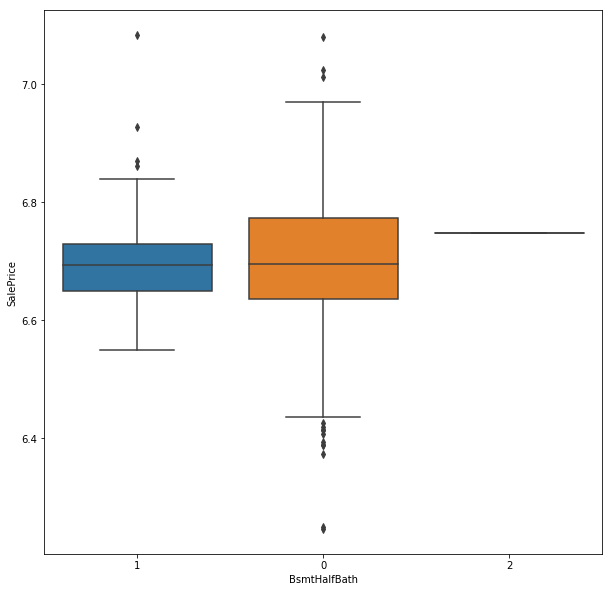

In [5031]:
boxplot_cat('BsmtHalfBath')

In [5032]:
group_count('BsmtHalfBath')

BsmtHalfBath
0    94.152626
1     5.748266
2     0.099108
Name: Id, dtype: float64


In [5033]:
train.drop('BsmtHalfBath',axis=1,inplace=True)

In [5034]:
train['FullBath'].unique()

array([2, 1, 3, 0], dtype=int64)

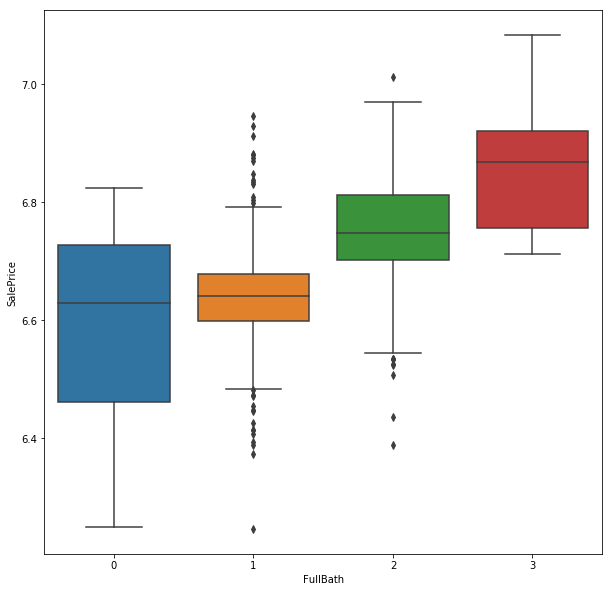

In [5035]:
boxplot_cat('FullBath')

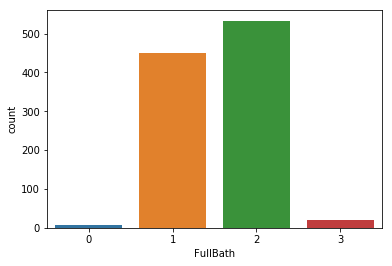

In [5036]:
sb.countplot(train['FullBath'])

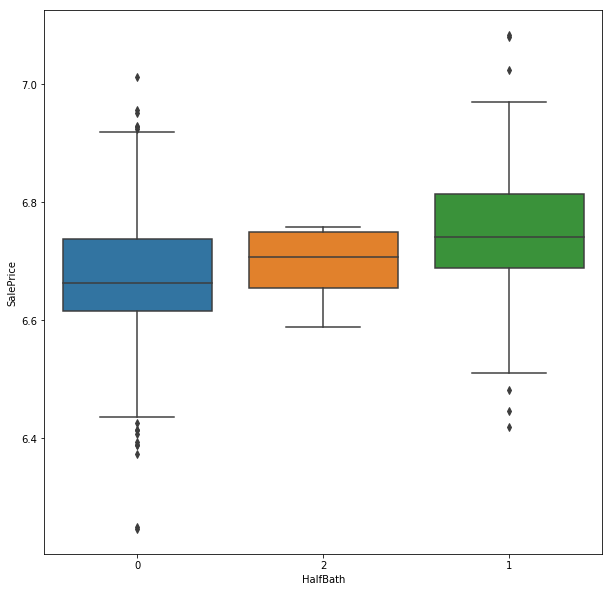

In [5037]:
boxplot_cat('HalfBath')

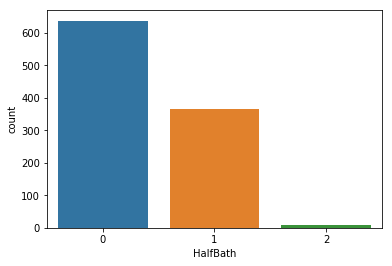

In [5038]:
sb.countplot(train['HalfBath'])

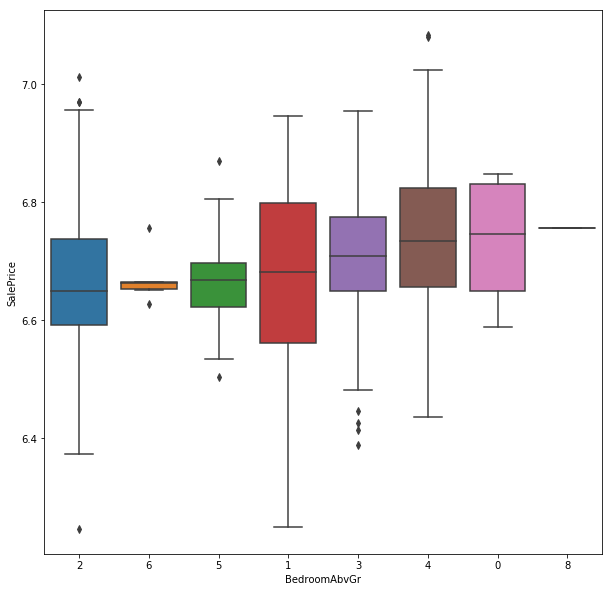

In [5039]:
boxplot_cat('BedroomAbvGr')

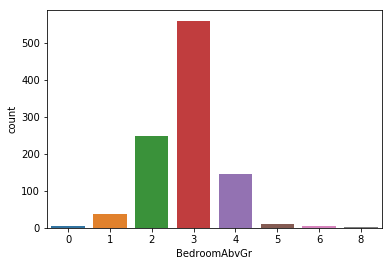

In [5040]:
sb.countplot(train['BedroomAbvGr'])

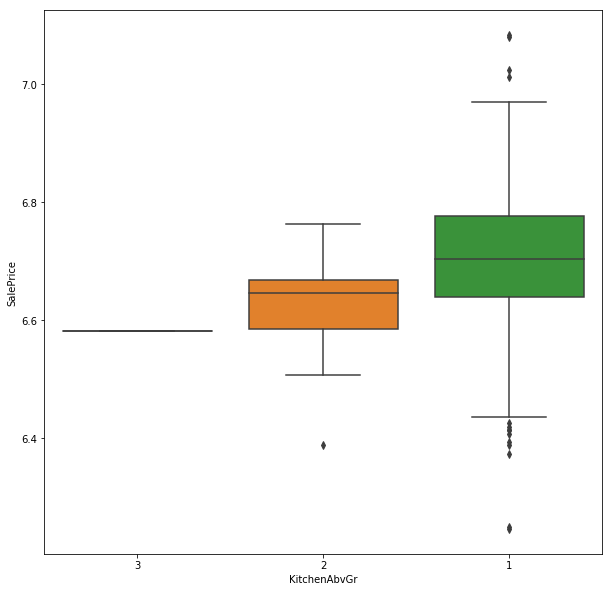

In [5041]:
boxplot_cat('KitchenAbvGr')

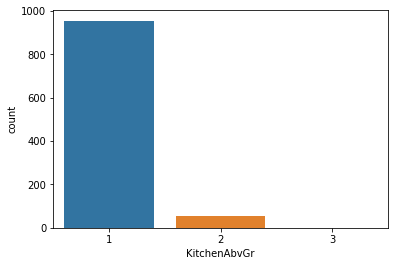

In [5042]:
sb.countplot(train['KitchenAbvGr'])

In [5043]:
group_count('KitchenAbvGr')

KitchenAbvGr
1    94.648167
2     5.252725
3     0.099108
Name: Id, dtype: float64


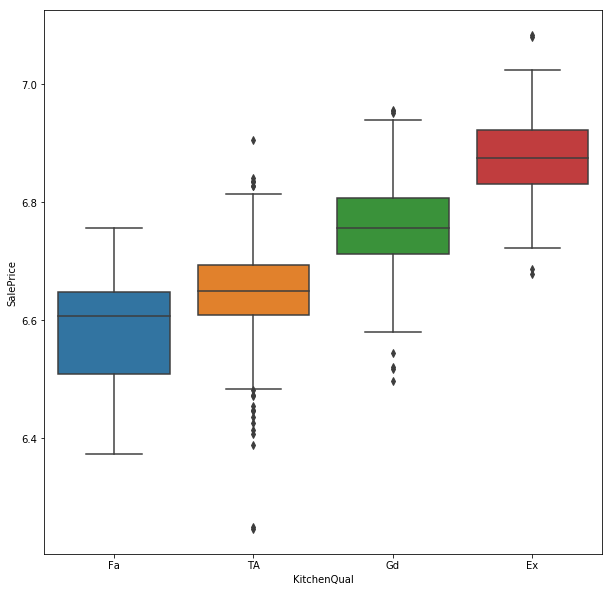

In [5044]:
boxplot_cat('KitchenQual')

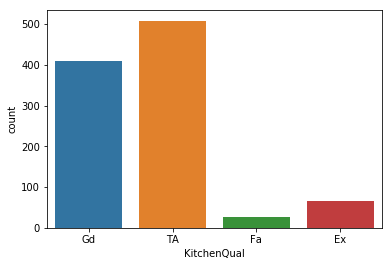

In [5045]:
sb.countplot(train['KitchenQual'])

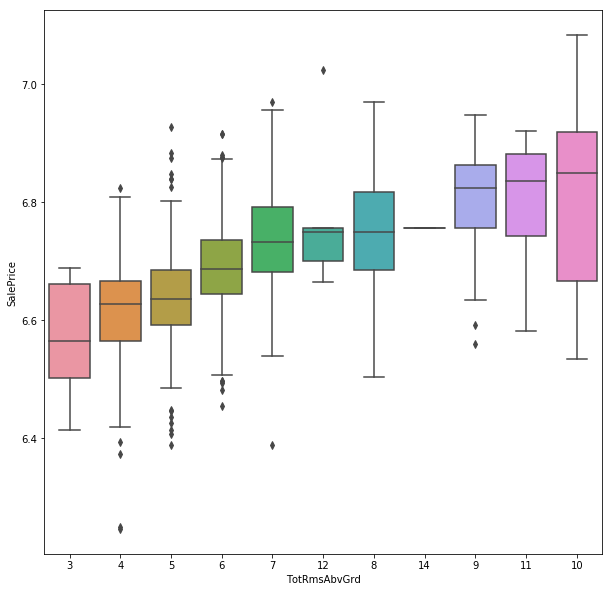

In [5046]:
boxplot_cat('TotRmsAbvGrd')

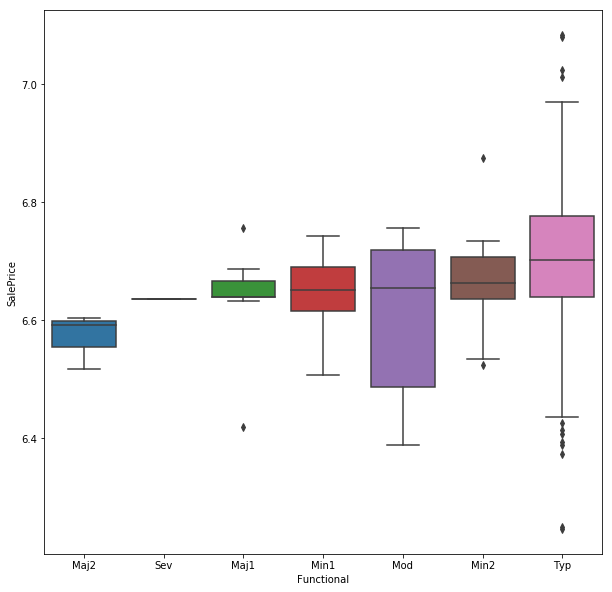

In [5047]:
boxplot_cat('Functional')

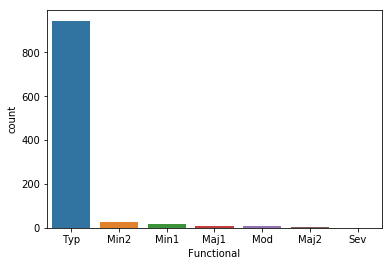

In [5048]:
sb.countplot(train['Functional'])

In [5049]:
group_count('Functional')

Functional
Maj1     0.891972
Maj2     0.297324
Min1     1.783944
Min2     2.576809
Mod      0.693756
Sev      0.099108
Typ     93.657086
Name: Id, dtype: float64


In [5050]:
train.drop('Functional',axis=1,inplace=True)

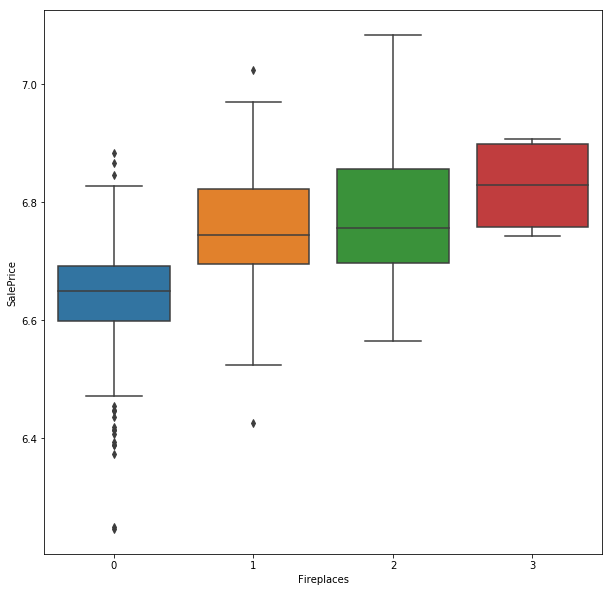

In [5051]:
boxplot_cat('Fireplaces')

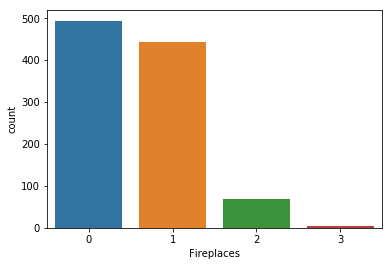

In [5052]:
sb.countplot(train['Fireplaces'])

In [5053]:
train['FireplaceQu'].unique()

array(['TA', 'Gd', nan, 'Po', 'Ex', 'Fa'], dtype=object)

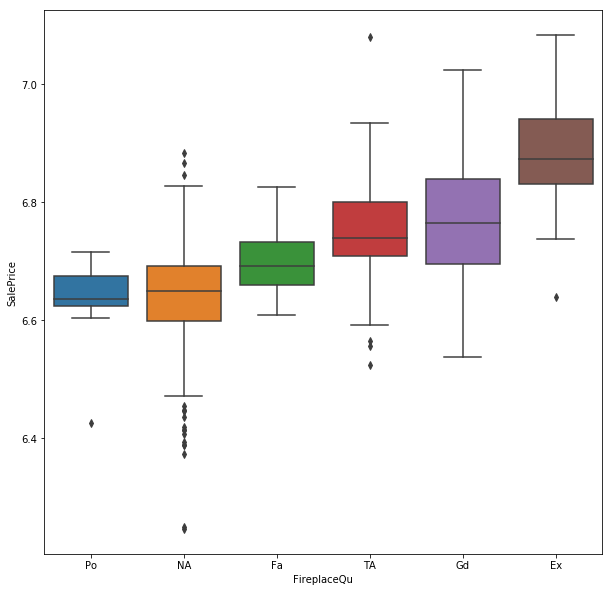

In [5054]:
train['FireplaceQu'].fillna('NA',inplace=True)
boxplot_cat('FireplaceQu')

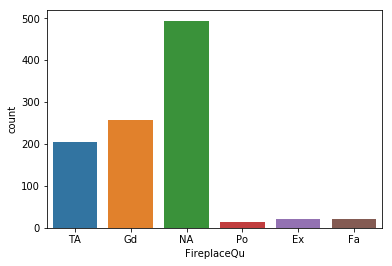

In [5055]:
sb.countplot(train['FireplaceQu'])

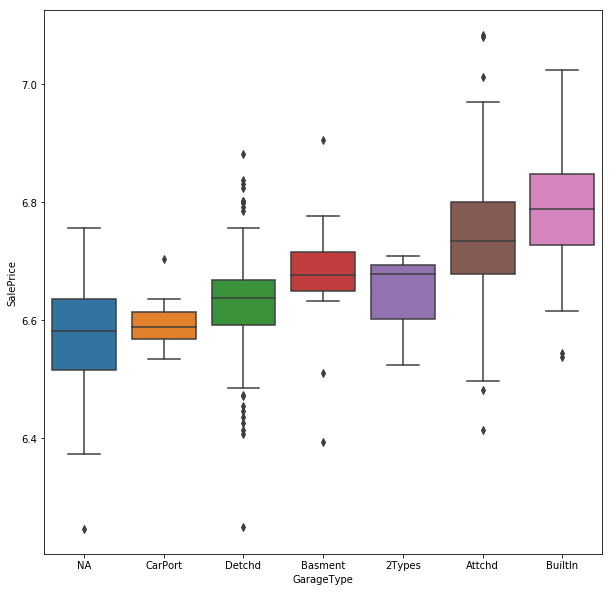

In [5056]:
train['GarageType'].fillna('NA',inplace=True)
boxplot_cat('GarageType')

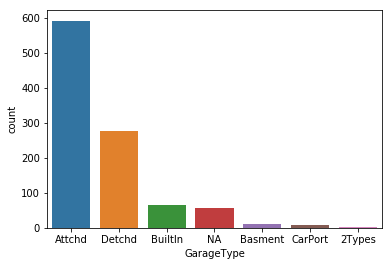

In [5057]:
sb.countplot(train['GarageType'])

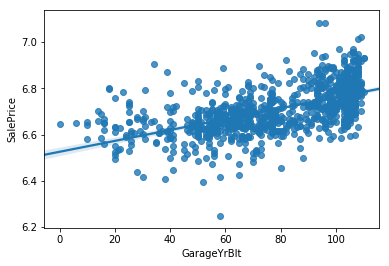

In [5058]:
sb.regplot(x=train['GarageYrBlt']-1900,y=train['SalePrice'])

In [5059]:
train['GarageYrBlt']=train['GarageYrBlt'] - 1900
train['GarageYrBlt'].fillna(-1,inplace=True)

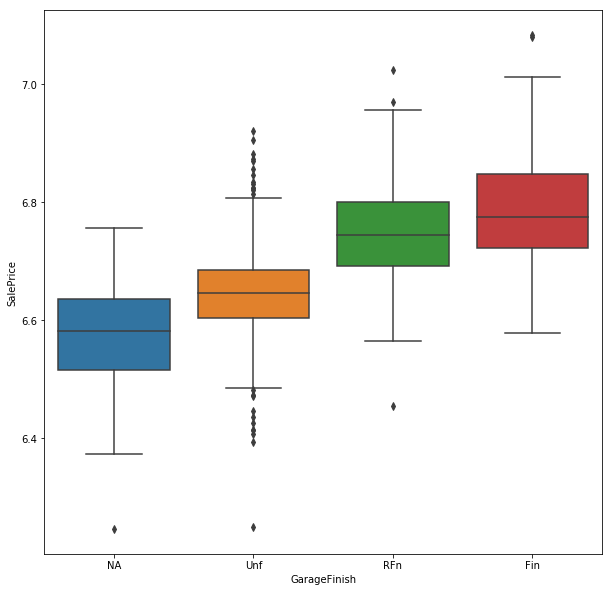

In [5060]:
train['GarageFinish'].fillna('NA',inplace=True)
boxplot_cat('GarageFinish')

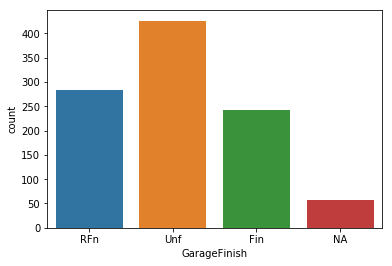

In [5061]:
sb.countplot(train['GarageFinish'])

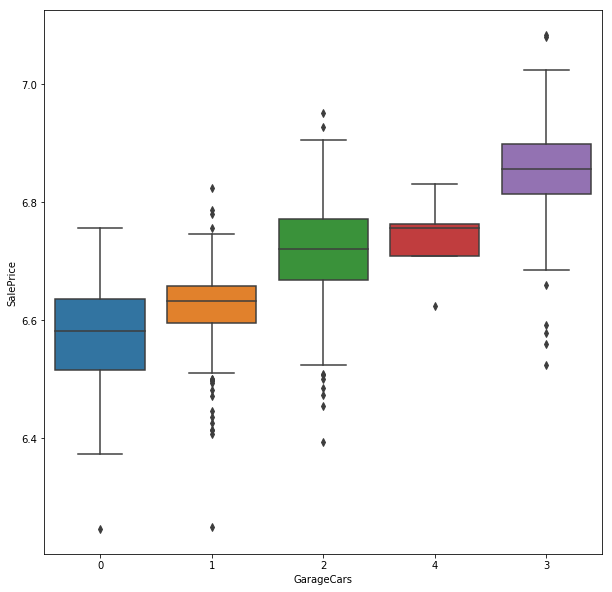

In [5062]:
boxplot_cat('GarageCars')

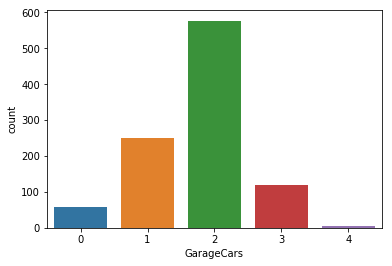

In [5063]:
sb.countplot(train['GarageCars'])

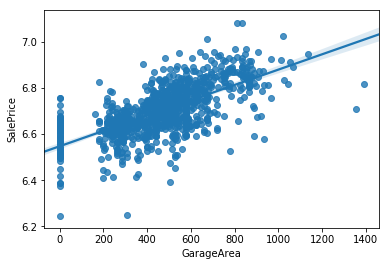

In [5064]:
sb.regplot(x=train['GarageArea'],
           y=train['SalePrice'])

In [5065]:
train[['GarageArea','SalePrice']].corr()

,GarageArea,SalePrice
GarageArea,1.000000,0.657308
SalePrice,0.657308,1.000000


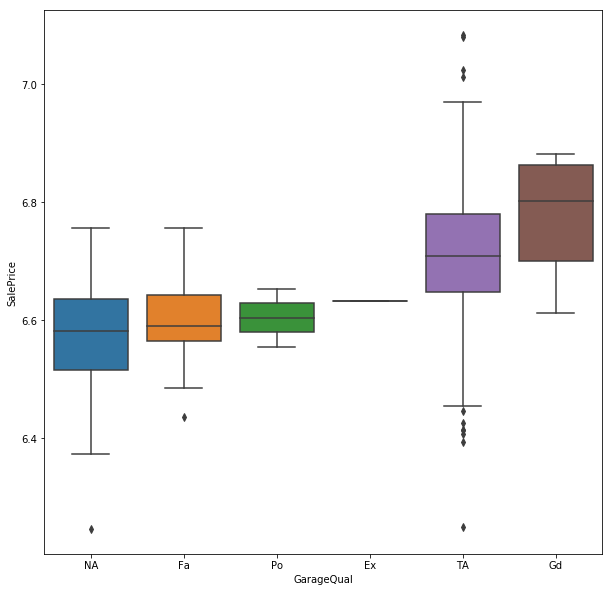

In [5066]:
train['GarageQual'].fillna('NA',inplace=True)
boxplot_cat('GarageQual')

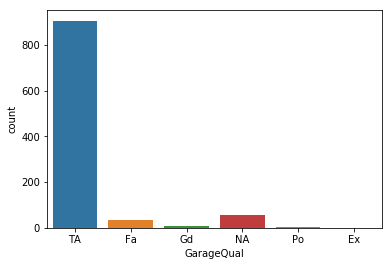

In [5067]:
sb.countplot(train['GarageQual'])

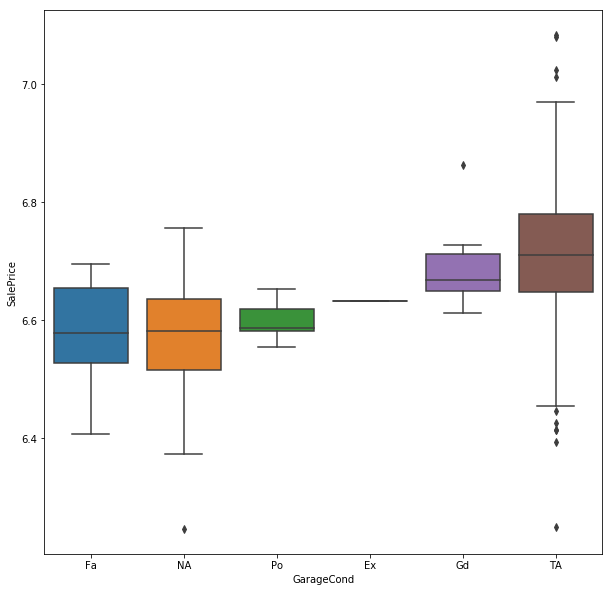

In [5068]:
train['GarageCond'].fillna('NA',inplace=True)
boxplot_cat('GarageCond')

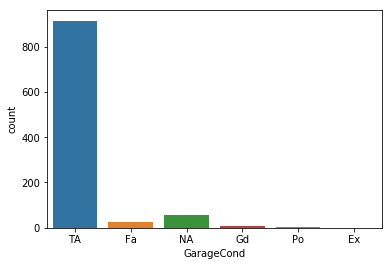

In [5069]:
sb.countplot(train['GarageCond'])

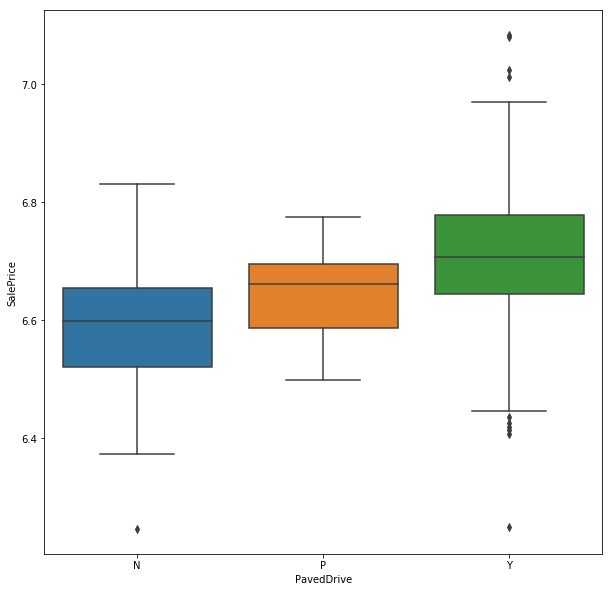

In [5070]:
boxplot_cat('PavedDrive')

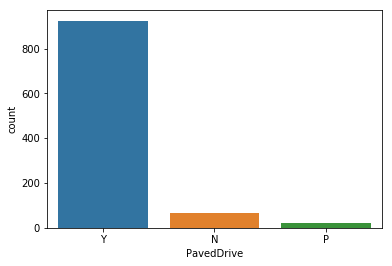

In [5071]:
sb.countplot(train['PavedDrive'])

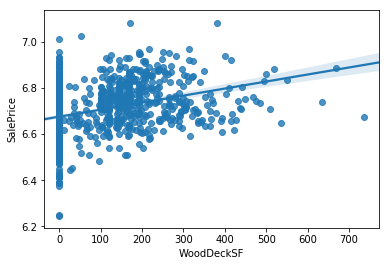

In [5072]:
sb.regplot(x=train['WoodDeckSF'],y=train['SalePrice'])

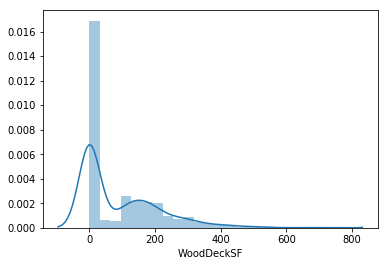

In [5073]:
sb.distplot(train['WoodDeckSF'])

In [5074]:
train[train['WoodDeckSF']!=0][['WoodDeckSF','SalePrice']].corr()

,WoodDeckSF,SalePrice
WoodDeckSF,1.000000,0.161937
SalePrice,0.161937,1.000000


In [5075]:
train.drop('WoodDeckSF',axis=1,inplace=True)

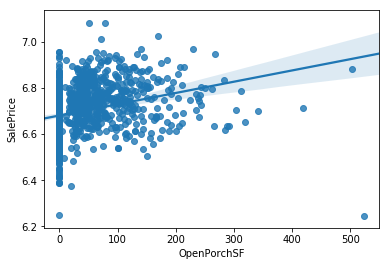

In [5076]:
sb.regplot(x=train['OpenPorchSF'],y=train['SalePrice'])

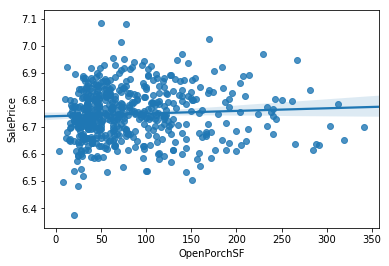

In [5077]:
sb.regplot(x=train[(train['OpenPorchSF']!=0) & (train['OpenPorchSF']<400)]['OpenPorchSF'],
           y=train[(train['OpenPorchSF']!=0) & (train['OpenPorchSF']<400)]['SalePrice'])

In [5078]:
train[['OpenPorchSF','SalePrice']].corr()

,OpenPorchSF,SalePrice
OpenPorchSF,1.000000,0.297104
SalePrice,0.297104,1.000000


In [5079]:
train.drop('OpenPorchSF',axis=1,inplace=True)

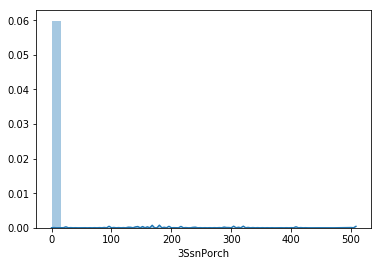

In [5080]:
sb.distplot(train['3SsnPorch'])

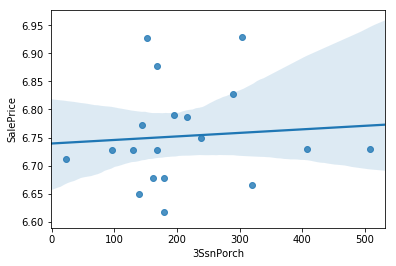

In [5081]:
sb.regplot(x=train[(train['3SsnPorch']!=0)]['3SsnPorch'],
           y=train[(train['3SsnPorch']!=0)]['SalePrice'])

In [5082]:
train.drop('3SsnPorch',axis=1,inplace=True)

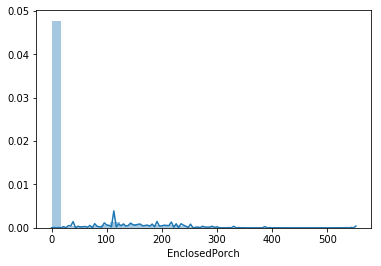

In [5083]:
sb.distplot(train['EnclosedPorch'])

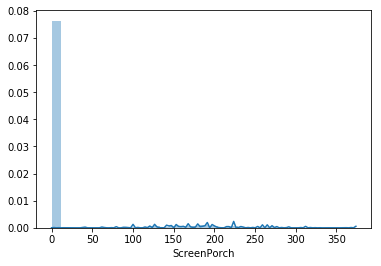

In [5084]:
sb.distplot(train['ScreenPorch'])

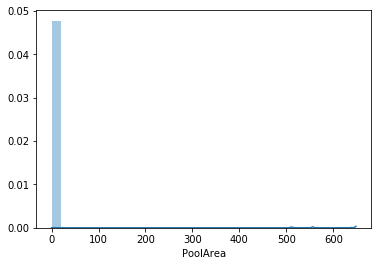

In [5085]:
sb.distplot(train['PoolArea'])

In [5086]:
train.drop(['ScreenPorch','PoolArea'],axis=1,inplace=True)

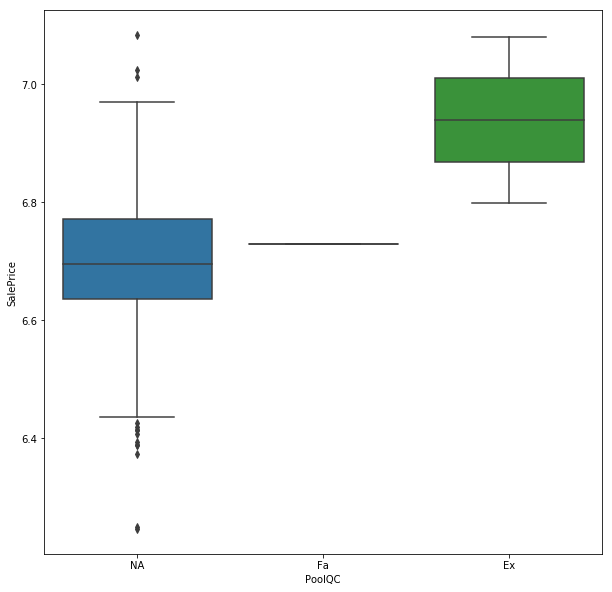

In [5087]:
train['PoolQC'] = train['PoolQC'].fillna('NA')
boxplot_cat('PoolQC')

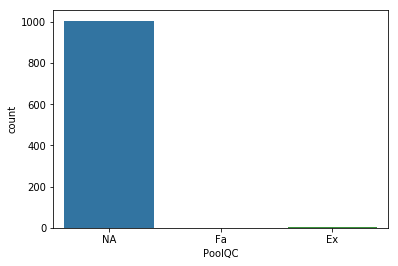

In [5088]:
sb.countplot(train['PoolQC'])

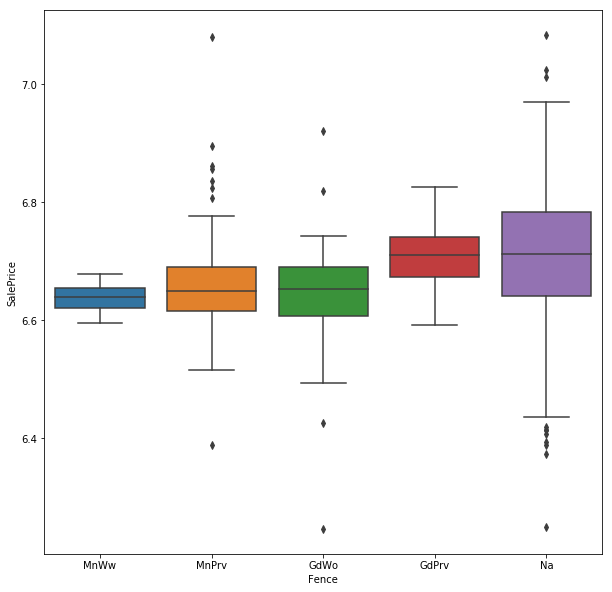

In [5089]:
train['Fence'] = train['Fence'].fillna('Na')
boxplot_cat('Fence')

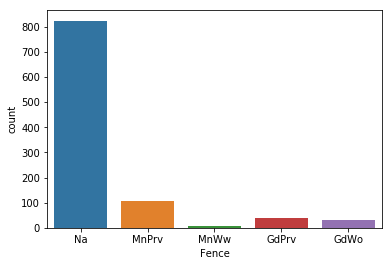

In [5090]:
sb.countplot(train['Fence'])

In [5091]:
group_count('Fence')

Fence
GdPrv     3.766105
GdWo      3.270565
MnPrv    10.604559
MnWw      0.693756
Na       81.665015
Name: Id, dtype: float64


In [5092]:
train.drop('Fence',axis=1,inplace=True)

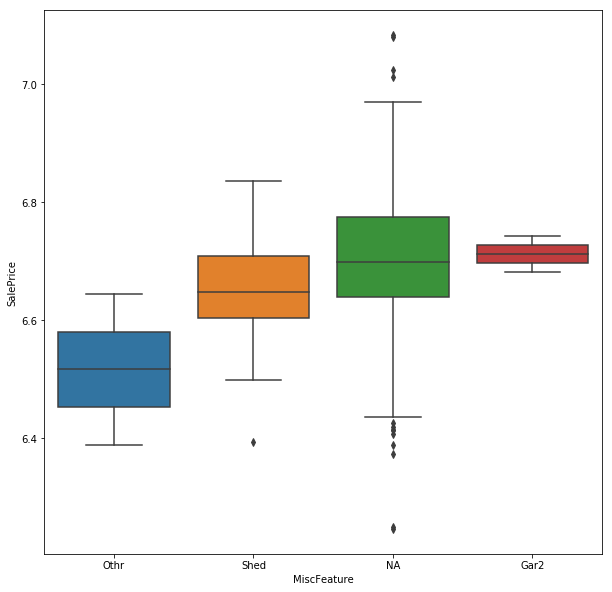

In [5093]:
train['MiscFeature'] = train['MiscFeature'].fillna('NA')
boxplot_cat('MiscFeature')

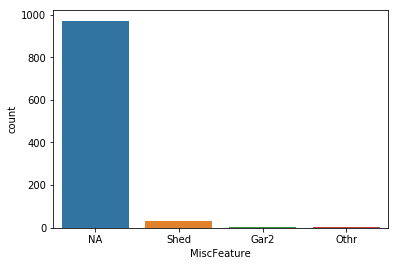

In [5094]:
sb.countplot(train['MiscFeature'])

In [5095]:
group_count('MiscFeature')

MiscFeature
Gar2     0.198216
NA      96.233895
Othr     0.198216
Shed     3.369673
Name: Id, dtype: float64


In [5096]:
train.drop('MiscFeature',axis=1,inplace=True)

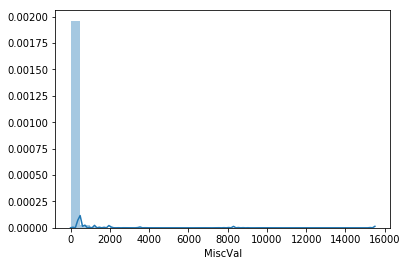

In [5097]:
sb.distplot(train['MiscVal'])

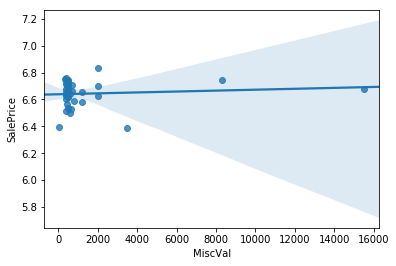

In [5098]:
sb.regplot(x=train[train['MiscVal']!=0]['MiscVal'],y=train[train['MiscVal']!=0]['SalePrice'])

In [5099]:
train.drop('MiscVal',axis=1,inplace=True)

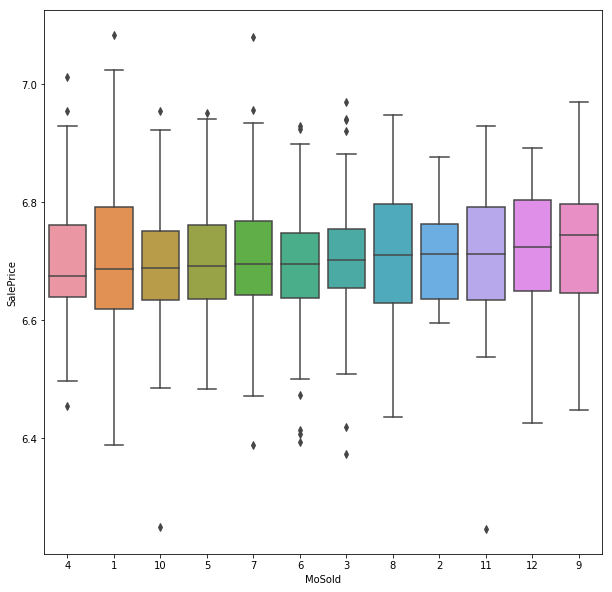

In [5100]:
boxplot_cat('MoSold')

In [5101]:
train.drop('MoSold',axis=1,inplace=True)

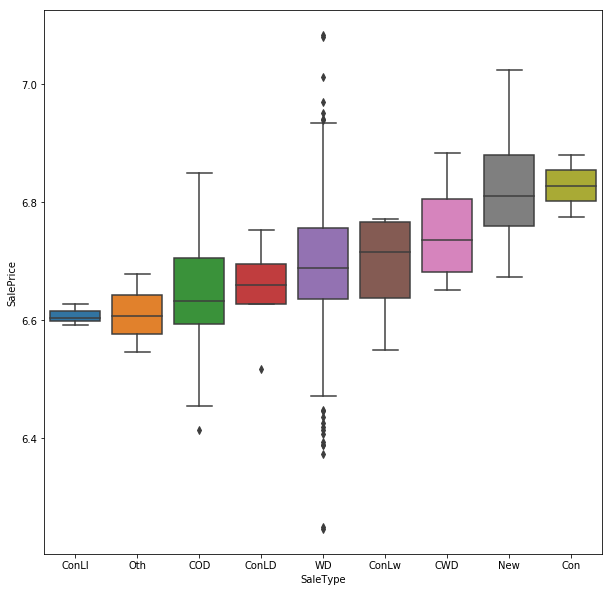

In [5102]:
boxplot_cat('SaleType',(10,10))

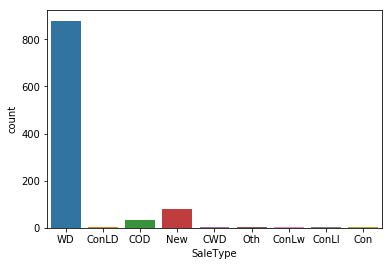

In [5103]:
sb.countplot(train['SaleType'])

In [5104]:
group_count('SaleType')

SaleType
COD       3.072349
CWD       0.396432
Con       0.198216
ConLD     0.495540
ConLI     0.297324
ConLw     0.396432
New       7.730426
Oth       0.297324
WD       87.115956
Name: Id, dtype: float64


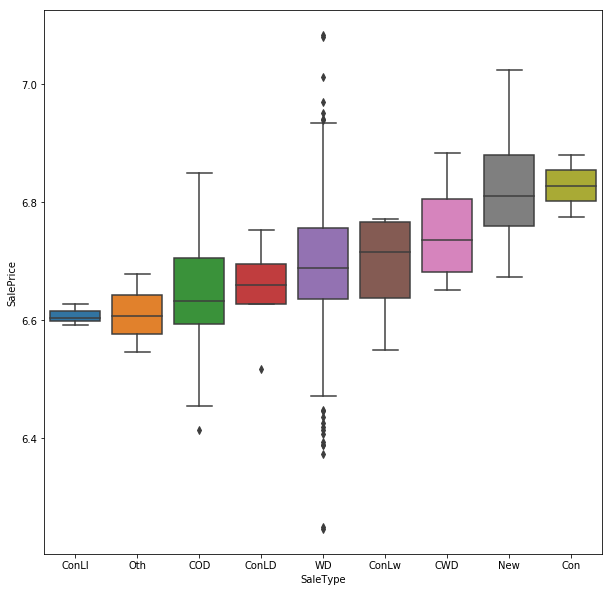

In [5105]:
boxplot_cat('SaleType')

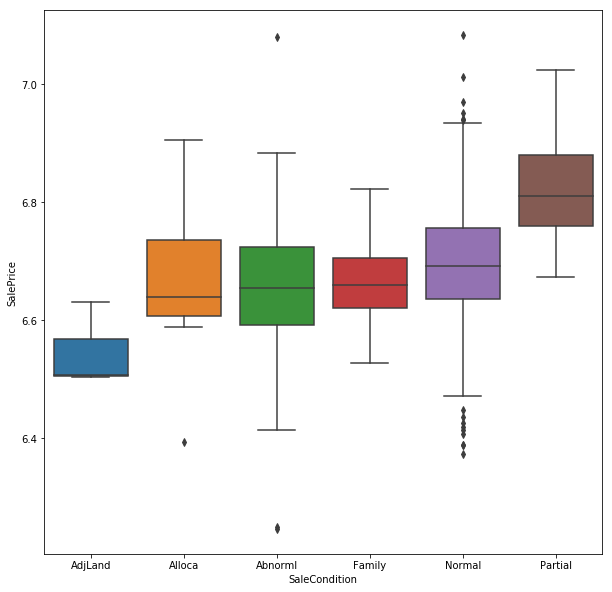

In [5106]:
boxplot_cat('SaleCondition')

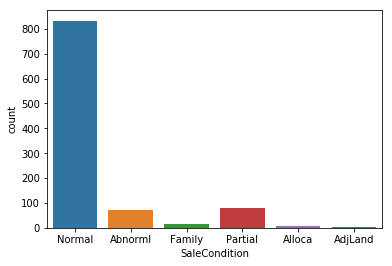

In [5107]:
sb.countplot(train['SaleCondition'])

In [5108]:
group_count('SaleCondition')

SaleCondition
Abnorml     7.234886
AdjLand     0.297324
Alloca      0.792864
Family      1.387512
Normal     82.556987
Partial     7.730426
Name: Id, dtype: float64


In [5109]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1009 entries, 318 to 792
Data columns (total 58 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1009 non-null   int64  
 1   MSSubClass     1009 non-null   int64  
 2   MSZoning       1009 non-null   object 
 3   LotFrontage    1009 non-null   float64
 4   LotArea        1009 non-null   int64  
 5   Alley          1009 non-null   object 
 6   LotShape       1009 non-null   object 
 7   LandContour    1009 non-null   object 
 8   Neighborhood   1009 non-null   object 
 9   Condition1     1009 non-null   object 
 10  BldgType       1009 non-null   object 
 11  HouseStyle     1009 non-null   object 
 12  OverallQual    1009 non-null   int64  
 13  OverallCond    1009 non-null   int64  
 14  RoofStyle      1009 non-null   object 
 15  Exterior1st    1009 non-null   object 
 16  Exterior2nd    1009 non-null   object 
 17  MasVnrType     1009 non-null   object 
 18  MasVnrA

In [5110]:
test['age'] = test['YrSold']-test['YearBuilt']
test['remodel_age'] = test['YrSold'] - test['YearRemodAdd']
columns_left = list(train.columns)
columns_to_drop = set(original_columns).difference(set(columns_left))
test.drop(list(columns_to_drop),axis=1,inplace=True)

In [5111]:
train['HeatingQC'].unique()

array(['Ex', 'TA', 'Gd', 'Fa', 'Po'], dtype=object)

In [5112]:
ordinal_mapping= {'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5 }

In [5113]:
ordinal_cat = ['PoolQC','GarageCond','GarageQual','FireplaceQu','KitchenQual','HeatingQC','BsmtQual','BsmtCond','ExterQual'
               ,'ExterCond']

In [5114]:
for col in ordinal_cat:
    train[col] = train[col].map(ordinal_mapping)

In [5115]:
train = pd.get_dummies(train,drop_first=True)

In [5116]:
test['LotFrontage'] = test.apply(lambda x:74 if np.isnan(x['LotFrontage']) and x['LotShape']=='IR1' else x['LotFrontage'],axis=1)
test['LotFrontage'] = test.apply(lambda x:65 if np.isnan(x['LotFrontage']) and x['LotShape']=='Reg' else x['LotFrontage'],axis=1)
test['LotFrontage'] = test.apply(lambda x:66 if np.isnan(x['LotFrontage']) and x['LotShape']=='IR2' else x['LotFrontage'],axis=1)
test['LotFrontage'] = test.apply(lambda x:116 if np.isnan(x['LotFrontage']) and x['LotShape']=='IR3' else x['LotFrontage'],axis=1)


In [5117]:
train.shape

(1009, 170)

In [5118]:
test['MasVnrArea'].fillna(0,inplace=True)

In [5119]:
test['SalePrice'] = pt.transform(test[['SalePrice']])
test['MasVnrType'].fillna('None',inplace=True)
test['GarageYrBlt'] = test["GarageYrBlt"] - 1900
test['GarageYrBlt'].fillna(-1,inplace=True)
test['MasVnrArea'].replace('NA')
test.fillna('NA',inplace=True)
for col in ordinal_cat:
    test[col] = test[col].map(ordinal_mapping)

In [5120]:
test = pd.get_dummies(test,drop_first=True)
#test.drop(['Electrical_NA','Electrical_Mix','Exterior2nd_Other'],axis=1,inplace=True)

In [5121]:
print(len(test.columns),len(train.columns))
print(set(test.columns).difference(set(train.columns)))
print(set(train.columns).difference(set(test.columns)))
train.drop(list(set(train.columns).difference(set(test.columns))),axis=1,inplace=True)
test.drop(list(set(test.columns).difference(set(train.columns))),axis=1,inplace=True)

159 170
{'Electrical_NA', 'Exterior2nd_Other', 'Electrical_Mix'}
{'RoofStyle_Shed', 'SaleType_Con', 'Condition1_RRNe', 'Exterior1st_CBlock', 'SaleType_Oth', 'Condition1_RRAe', 'Exterior1st_AsphShn', 'Exterior1st_ImStucc', 'Exterior1st_BrkComm', 'Neighborhood_Veenker', 'Exterior2nd_CBlock', 'Electrical_FuseP', 'SaleType_CWD', 'Exterior1st_Stone'}


In [5122]:
print(set(test.columns).difference(set(train.columns)))
print(set(train.columns).difference(set(test.columns)))

set()
set()


In [5123]:
#Selecting top  50 features using RFE
model = LinearRegression()
eliminator = RFE(model,n_features_to_select=50)
eliminator = eliminator.fit(train.drop(['Id','SalePrice'],axis=1),train['SalePrice'])
df = pd.DataFrame({'rank':eliminator.ranking_,'columns':list(train.drop(['Id','SalePrice'],axis=1).columns)})

In [5124]:
y = train['SalePrice'].values
y_test = test['SalePrice'].values
train_x = train[list(df[df['rank']==1]['columns'])]
test_x = test[list(df[df['rank']==1]['columns'])]


In [5125]:
print(len(train_x.columns),len(test_x.columns))

50 50


In [5126]:
alpha = np.arange(0.01,100,0.5)

In [5127]:
alpha.shape

(200,)

In [5128]:
r2_test = []
r2_train = []
neg_mean_test = []
neg_mean_train = []
X = train_x.values
for i in range(200):
    model=Ridge(alpha=alpha[i])
    scores = cross_validate(model,X,y,cv=5,scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)
    test_r2 = np.mean(scores['test_r2'])
    test_neg_mean = np.mean(scores['test_neg_mean_squared_error'])
    train_r2 = np.mean(scores['train_r2'])
    train_neg_mean = np.mean(scores['train_neg_mean_squared_error'])
    r2_test.append(test_r2)
    r2_train.append(train_r2)
    neg_mean_test.append(test_neg_mean)
    neg_mean_train.append(train_neg_mean)
    

R2 max 0.8602369033666017 for test set at alpha 1.01


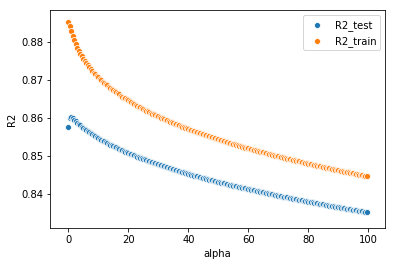

In [5129]:
plt.xlabel('alpha')
plt.ylabel('R2')
sb.scatterplot(x=alpha,y=r2_test,label='R2_test')
sb.scatterplot(x=alpha,y=r2_train,label='R2_train')
plt.legend()
print(f"R2 max {max(r2_test)} for test set at alpha {alpha[r2_test.index(max(r2_test))]}")

Neg Mean Squared max -0.0015611314177859813 for test set at alpha 0.51


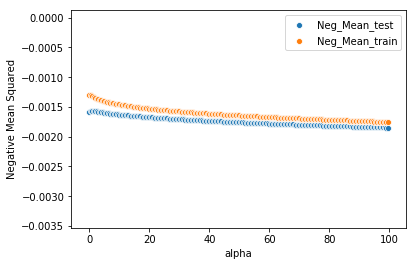

In [5130]:
plt.xlabel('alpha')
plt.ylabel('Negative Mean Squared')
sb.scatterplot(x=alpha,y=neg_mean_test,label='Neg_Mean_test')
sb.scatterplot(x=alpha,y=neg_mean_train,label='Neg_Mean_train')
plt.legend()
print(f"Neg Mean Squared max {max(neg_mean_test)} for test set at alpha {alpha[neg_mean_test.index(max(neg_mean_test))]}")

In [5131]:
ridge_model = Ridge(alpha=1.01).fit(train_x.values,y)


ridge_coeff = pd.DataFrame({"coeffs":np.abs(ridge_model.coef_),"column_name":list(train_x.columns)})

In [5132]:
#Selecting top features based on coefficient value
ridge_coeff.sort_values('coeffs',ascending=False).head(10)

,coeffs,column_name
11,0.083172,MSZoning_RL
10,0.082712,MSZoning_RH
9,0.066111,MSZoning_FV
12,0.065993,MSZoning_RM
38,0.052704,Foundation_Stone
30,0.045866,Exterior2nd_Brk Cmn
14,0.045395,Neighborhood_Crawfor
22,0.040574,Condition1_PosA
16,0.037373,Neighborhood_NoRidge
4,0.036005,KitchenAbvGr


In [5133]:
y_pred=ridge_model.predict(test_x.values)

In [5134]:
r2_score(y_pred=y_pred,y_true=y_test)

0.8435423163389728

In [5135]:
alpha = np.arange(0,100,0.5)
r2_test = []
r2_train = []
neg_mean_test = []
neg_mean_train = []
X = train_x.values

for i in range(200):
    model=Lasso(alpha=alpha[i])
    scores = cross_validate(model,X,y,cv=5,scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)
    test_r2 = np.mean(scores['test_r2'])
    test_neg_mean = np.mean(scores['test_neg_mean_squared_error'])
    train_r2 = np.mean(scores['train_r2'])
    train_neg_mean = np.mean(scores['train_neg_mean_squared_error'])
    r2_test.append(test_r2)
    r2_train.append(train_r2)
    neg_mean_test.append(test_neg_mean)
    neg_mean_train.append(train_neg_mean)

R2 max 0.857613171967604 for test set at alpha 0.0


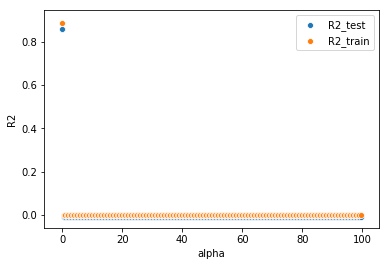

In [5136]:
plt.xlabel('alpha')
plt.ylabel('R2')
sb.scatterplot(x=alpha,y=r2_test,label='R2_test')
sb.scatterplot(x=alpha,y=r2_train,label='R2_train')
plt.legend()
print(f"R2 max {max(r2_test)} for test set at alpha {alpha[r2_test.index(max(r2_test))]}")

Neg Mean Squared max -0.0015836279515538943 for test set at alpha 0.0


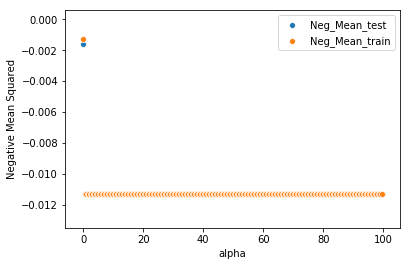

In [5137]:
plt.xlabel('alpha')
plt.ylabel('Negative Mean Squared')
sb.scatterplot(x=alpha,y=neg_mean_test,label='Neg_Mean_test')
sb.scatterplot(x=alpha,y=neg_mean_train,label='Neg_Mean_train')
plt.legend()
print(f"Neg Mean Squared max {max(neg_mean_test)} for test set at alpha {alpha[neg_mean_test.index(max(neg_mean_test))]}")

In [5138]:
lasso_model = Lasso(alpha=0).fit(X,y)

In [5139]:
Lasso_coeff = pd.DataFrame({"coeffs":np.abs(lasso_model.coef_),"column_name":list(train_x.columns)})

In [5140]:
y_pred=lasso_model.predict(test_x.values)

In [5141]:
r2_score(y_pred,y_test)

0.8150527019218159

In [5142]:
Lasso_coeff.sort_values('coeffs',ascending=False).head(10)

,coeffs,column_name
10,0.139242,MSZoning_RH
11,0.132628,MSZoning_RL
9,0.119817,MSZoning_FV
12,0.116612,MSZoning_RM
38,0.073104,Foundation_Stone
30,0.055594,Exterior2nd_Brk Cmn
22,0.050184,Condition1_PosA
47,0.048243,SaleType_ConLD
14,0.047062,Neighborhood_Crawfor
43,0.041505,GarageType_NA


### Summary
We  observe the followng points from the models:
* Lasso doesn't reduce the number of variables implying the top 50 features are equally important 
* As expected Zone,Foundation,Exterior , Condition,Saletype and Neighbourhood are the significant variables.

In [5143]:
#ques1
alpha_ridge = 1.01*2
alpha_lasso = 0
ridge_model = Ridge(alpha=alpha_ridge).fit(X,y)
ridge_coeff = pd.DataFrame({"coeffs":np.abs(ridge_model.coef_),"column_name":list(train_x.columns)})
print(ridge_coeff.sort_values('coeffs',ascending=False).head(10))

      coeffs           column_name
11  0.062542           MSZoning_RL
10  0.058818           MSZoning_RH
9   0.045371           MSZoning_FV
12  0.044434           MSZoning_RM
14  0.043757  Neighborhood_Crawfor
38  0.040834      Foundation_Stone
30  0.039169   Exterior2nd_Brk Cmn
16  0.035300  Neighborhood_NoRidge
4   0.034585          KitchenAbvGr
41  0.034237          CentralAir_Y


In [5144]:
#ques3
train_x=train_x.drop(['MSZoning_RH','MSZoning_RL','MSZoning_FV','MSZoning_RM','Foundation_Stone'],axis=1)
X = train_x.values
ridge_model = Ridge(alpha=1.01).fit(X,y)
ridge_coeff = pd.DataFrame({"coeffs":np.abs(ridge_model.coef_),"column_name":list(train_x.columns)})
print(ridge_coeff.sort_values('coeffs',ascending=False).head(10))


      coeffs           column_name
10  0.047287  Neighborhood_Crawfor
26  0.042562   Exterior2nd_Brk Cmn
18  0.041705       Condition1_PosA
21  0.041341        BldgType_Twnhs
36  0.038431          CentralAir_Y
4   0.037214          KitchenAbvGr
12  0.037153  Neighborhood_NoRidge
9   0.032473  Neighborhood_ClearCr
11  0.031984  Neighborhood_MeadowV
19  0.030155       Condition1_PosN


In [5145]:
train_x=train_x.drop(['MSZoning_RH','MSZoning_RL','MSZoning_FV','MSZoning_RM','Foundation_Stone'],axis=1)
X = train_x.values
ridge_model = Lasso(alpha=0).fit(X,y)
ridge_coeff = pd.DataFrame({"coeffs":np.abs(ridge_model.coef_),"column_name":list(train.columns)})
print(ridge_coeff.sort_values('coeffs',ascending=False).head(10))


KeyError: "['MSZoning_RH' 'MSZoning_RL' 'MSZoning_FV' 'MSZoning_RM'\n 'Foundation_Stone'] not found in axis"